**Bayesian Optimisation for hyperparameter configuration**

**Set random seed for reproducability**

In [1]:
import os
import numpy as np 
import tensorflow as tf
randseed = 42
np.random.seed(randseed)
tf.random.set_seed(randseed)
os.environ['PYTHONHASHSEED']=str(randseed)

**Import packages**

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from keras import backend as K
from keras.models import Sequential, load_model 
from keras.layers import Dense, Dropout, GRU 
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler  
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score
import skopt
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer

**Read in dataset**

In [3]:
#Read in the Dataset
original = pd.read_csv('/kaggle/input/stocks/AFX.csv') 
original['Date'] = pd.to_datetime(original.Date) 
original.head()

Date  Open  High  Low  Close   Volume  Earnings Yield (EY)  \
0 1999-01-01   700   701  700    700        0                 10.2   
1 1999-01-04   680   680  670    670     1500                 10.7   
2 1999-01-05   670   674  665    670    82533                 10.7   
3 1999-01-06   675   700  675    700    32680                 10.2   
4 1999-01-07   710   730  710    730  1457342                  9.8   

   Dividend Yield (DY)  P:E Ratio (P:E) Trades Trade Value  \
0                  5.4         9.803922      -           -   
1                  5.6         9.345794      -           -   
2                  5.6         9.345794      -           -   
3                  5.4         9.803922      -           -   
4                  5.2        10.204082      -           -   

   Total Return Index (TRI)  
0                      80.0  
1                      76.0  
2                      76.0  
3                      80.0  
4                      83.0

**Feature Engineering:**

*   Variations of Log Returns
*   Total Return Index (TRI)
*   Simple Moving Average (SMA) - 20, 50, 200 days
*   Exponentially-weighted Moving Average (EWMA) - 20, 50, 200 days
*   Moving Average Convergence Divergence (MACD)
*   Relative Strength Index (RSI) - 14 days
*   Moving Average Convergence Divergence (MACD)

In [4]:
forecastHorizon = 5

#Create new dataframe
df = pd.DataFrame(data = original['Date'])  

#Target Returns (Weekly)
df['Target'] = np.log(original['Close'].shift(-forecastHorizon) / original['Close'])

#Returns from the closing price
df['Returns'] = np.log((original['Close']) / original['Close'].shift(forecastHorizon))

#Lagged Variations of returns
df['Returns1'] = np.log((original['Close']) / original['Close'].shift(1))
df['Returns2'] = np.log((original['Close']) / original['Close'].shift(2))
df['Returns3'] = np.log((original['Close']) / original['Close'].shift(3))
df['Returns4'] = np.log((original['Close']) / original['Close'].shift(4))

#Simple Moving Average (SMA) and Exponentially-weighted Moving Average (EWMA) - 5, 10, 20, 50, 200 days
numDays = 5
df['SMA (5)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (5)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 10
df['SMA (10)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (10)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 20
df['SMA (20)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (20)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 50
df['SMA (50)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (50)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 200
df['SMA (200)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (200)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

#Relative Strength Index (RSI)
numDays = 14
diff = original['Close'].diff(1)
up, down = diff.copy(), diff.copy()
up[up < 0] = 0
down[down > 0] = 0
EWMAu = up.ewm(span = numDays, min_periods = numDays).mean()
EWMAd = down.abs().ewm(span = numDays, min_periods = numDays).mean()
RS = EWMAu / EWMAd
df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

#Moving Average Convergence Divergence (MACD)
df['MACD'] = df['Returns'].ewm(span = 12, min_periods = 12).mean()  - df['Returns'].ewm(span = 26, min_periods = 26).mean() 

#Commodity Channel Index (CCI) 
df['Typical Price'] = (original['High'] + original['Low'] + original['Close']) / 3
numDays = 20
df['CCI'] = (df['Typical Price'] - df['Typical Price'].rolling(numDays).mean()) / (0.015 * df['Typical Price'].rolling(numDays).std())

#Stochastic Oscillator (SO)
numDays = 14
df['SO'] = ((df['Returns'] - df['Returns'].rolling(numDays).min()) / (df['Returns'].rolling(numDays).max() - df['Returns'].rolling(numDays).min())) * 100

#Variations of Returns
df['TRI'] = np.log(original['Total Return Index (TRI)'] / original['Total Return Index (TRI)'].shift(forecastHorizon))
df['Returns Open'] = np.log(original['Open'] / original['Open'].shift(forecastHorizon))
df['Returns Low'] = np.log(original['Low'] / original['Low'].shift(forecastHorizon))
df['Returns High'] = np.log(original['High'] / original['High'].shift(forecastHorizon))
df['Returns High/Open'] = np.log(original['High'] / original['Open'].shift(forecastHorizon))
df['Returns High/Low'] = np.log(original['High'] / original['Low'].shift(forecastHorizon))
df['Returns High/Close'] = np.log(original['High'] / original['Close'].shift(forecastHorizon))
df['Returns Close/Open'] = np.log(original['Close'] / original['Open'].shift(forecastHorizon))
df['Returns Close/Low'] = np.log(original['Close'] / original['Low'].shift(forecastHorizon))
df['Returns Close/High'] = np.log(original['Close'] / original['High'].shift(forecastHorizon))
df['Returns Open/Low'] = np.log(original['Open'] / original['Low'].shift(forecastHorizon))
df['Typical Price'] = np.log(df['Typical Price'] / df['Typical Price'].shift(forecastHorizon))

#Set date to index
df.index = df['Date'] 

#Drop columns that aren't needed
df.drop(['Date'], axis=1, inplace=True)

#Drop NaNs
df = df.dropna()

df.head()

Target   Returns  Returns1  Returns2  Returns3  Returns4  \
Date                                                                     
1999-10-14 -0.009050 -0.026668   0.00905   0.00905   0.00905   0.00905   
1999-10-15  0.018019  0.000000  -0.00905   0.00000   0.00000   0.00000   
1999-10-18  0.000000  0.000000   0.00000  -0.00905   0.00000   0.00000   
1999-10-19  0.022473  0.000000   0.00000   0.00000  -0.00905   0.00000   
1999-10-20  0.044452  0.000000   0.00000   0.00000   0.00000  -0.00905   

             SMA (5)  EWMA (5)  SMA (10)  EWMA (10)  ...  Returns Open  \
Date                                                 ...                 
1999-10-14  0.057964  0.032314  0.055618   0.040250  ...      0.000000   
1999-10-15  0.032810  0.021543  0.057659   0.032932  ...     -0.026668   
1999-10-18  0.011738  0.014362  0.057659   0.026944  ...      0.000000   
1999-10-19 -0.005334  0.009575  0.055659   0.022045  ...      0.000000   
1999-10-20 -0.005334  0.006383  0.043596   0.018037  ...      0.000000   

            Returns Low  Returns High  Returns High/Open  Returns High/Low  \
Date                                                                         
1999-10-14      0.00000     -0.035402           0.009050          0.009050   
1999-10-15      0.00000     -0.026668          -0.026668          0.009050   
1999-10-18      0.00000     -0.022473           0.000000          0.000000   
1999-10-19      0.00000     -0.013544           0.000000          0.000000   
1999-10-20      0.02299      0.004535           0.004535          0.027525   

            Returns High/Close  Returns Close/Open  Returns Close/Low  \
Date                                                                    
1999-10-14           -0.026668            0.009050            0.00905   
1999-10-15            0.009050           -0.035718            0.00000   
1999-10-18            0.000000            0.000000            0.00000   
1999-10-19            0.000000            0.000000            0.00000   
1999-10-20            0.004535            0.000000            0.02299   

            Returns Close/High  Returns Open/Low  
Date                                              
1999-10-14           -0.035402           0.00000  
1999-10-15           -0.035718           0.00905  
1999-10-18           -0.022473           0.00000  
1999-10-19           -0.013544           0.00000  
1999-10-20            0.000000           0.02299  

[5 rows x 32 columns]

**Model Helper Functions**

In [5]:
def split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end):
  '''
  Function to split the data into a window required for Keras RNNs
  @params:
    dataset - data to be used
    sequencelength - Number of datapoints in a single input sequence
    features - Number of features in the dataset
    scaler - Initialised MinMaxScaler
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    testingSize - Size of the testing set
    end - Last datapoint index
  @returns:
    scaler - Scaler that is fit on the training data
    x_train - Scaled Training input 
    y_train - Scaled Training output 
    y_trainUnscaled - Unscaled training output 
    x_val - Scaled validation input 
    y_val - Scaled validation output 
    y_valUnscaled - Unscaled validation output 
    x_test - Scaled testing input 
    y_test - Unscaled testing output 
  '''
  #Extracting target variables for the test and train set
  train = scaler.fit_transform(dataset[start - sequencelength : start + trainingSize, :])
  unscaled_train = dataset[start - sequencelength : start + trainingSize , 0]

  x_train = []
  y_train = []
  y_trainUnscaled = []
  for i in range(sequencelength, len(train)):
    x_train.append(train[i - sequencelength + 1 : i + 1, 1:])
    y_train.append(train[i, 0])
    y_trainUnscaled.append(unscaled_train[i])

  x_train = np.array(x_train)
  x_train = x_train.reshape((x_train.shape[0], sequencelength, features))
  y_train = np.array(y_train)
  y_trainUnscaled = np.array(y_trainUnscaled)

  #Splitting the validation set into input and output arrays
  val = scaler.transform(dataset[start + trainingSize - sequencelength : end - testingSize, :])
  unscaled_val = dataset[start + trainingSize - sequencelength : end - testingSize , 0]

  x_val = []
  y_val = []
  y_valUnscaled = []
  for i in range(sequencelength, len(val)):
    x_val.append(val[i - sequencelength + 1 : i + 1, 1:])
    y_val.append(val[i, 0])
    y_valUnscaled.append(unscaled_val[i])

  x_val = np.array(x_val)
  x_val = x_val.reshape((x_val.shape[0], sequencelength, features))
  y_val = np.array(y_val)
  y_valUnscaled = np.array(y_valUnscaled)

  #Splitting the testing set into input an array
  test = scaler.transform(dataset[start + trainingSize + validationSize - sequencelength : end, :])
  unscaled_test = dataset[start + trainingSize + validationSize - sequencelength : end, 0]

  x_test = []
  y_test = []
  for i in range(sequencelength, len(test)):
    x_test.append(test[i - sequencelength + 1 : i + 1, 1:])
    y_test.append(unscaled_test[i])

  x_test = np.array(x_test) 
  x_test = x_test.reshape((x_test.shape[0], sequencelength, features))
  y_test = np.array(y_test)

  return scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test

def makePredictions(model, x_train, x_val, x_test, sequencelength, scaler):
  '''
  Performs inference using the model
  @params:
    model - LSTM or GRU (Keras Framework)
    x_train - Training input data
    x_val - Validation input data
    x_test - Testing input data
    sequencelength - Input sequence length
    scaler - MinMaxScaler used to scale the data
  @returns:
    trainingPredictions - Training set predictions
    valPredictions - Validation set predictions
    testingPredictions - Testing set predictions
  '''
  #Forecasts on training set
  temp = x_train
  trainingPredictions = model.predict(x_train)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((trainingPredictions, temp[:,:features]), axis=1)
  trainingPredictions = scaler.inverse_transform(invPred)[:,0]
  trainingPredictions = trainingPredictions.reshape((trainingPredictions.shape[0], 1))

  #Forecasts on validation set
  temp = x_val
  valPredictions = model.predict(x_val)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((valPredictions, temp[:,:features]), axis=1)
  valPredictions = scaler.inverse_transform(invPred)[:,0]
  valPredictions = valPredictions.reshape((valPredictions.shape[0], 1))

  #Forecasts on test set
  temp = x_test
  testingPredictions = model.predict(x_test)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((testingPredictions, temp[:,:features]), axis=1)
  testingPredictions = scaler.inverse_transform(invPred)[:,0]
  testingPredictions = testingPredictions.reshape((testingPredictions.shape[0], 1))

  return trainingPredictions, valPredictions, testingPredictions

**Parameters for the dataset split**

In [6]:
dataset = df.values
totaldatapoints = len(dataset)
features = len(df.columns) - 1

**Setting up hyperparameter ranges**

In [7]:
dim_learning_rate = Real(low=1e-4, high=1e-2, prior='log-uniform', name='learning_rate')
dim_num_input_nodes = Integer(low=5, high=256, name='num_input_nodes')
dim_dropout = Real(low=0.0,high=0.25,name='dropout')
dim_sequence_length = Integer(low=100, high=200, name='sequence_length')
dim_batch_size = Integer(low=1, high=250, name='batch_size')

dimensions = [dim_learning_rate,
              dim_num_input_nodes,
              dim_dropout,
              dim_sequence_length,
              dim_batch_size]

default_parameters = [3e-4, 256, 0.2, 200, 32]

**GRU initialisation based on current set of hyperparameters**

In [8]:
def gru(learning_rate, num_input_nodes, dropout, sequence_length):
  '''
  Create GRU
  @params: 
    learning_rate - Adam learning rate
    num_input_nodes - Number of GRU cells in the layers
    dropout - dropout regularisation
    sequence_length - Length of the input sequence length
  @returns:
    model - Compiled GRU
  '''
  #Construct GRU
  model = Sequential()
  model.add(GRU(units=num_input_nodes, return_sequences=True, input_shape=(sequence_length, features)))
  model.add(GRU(units=num_input_nodes, dropout=dropout))
  model.add(Dense(1))

  adam = Adam(lr=learning_rate, amsgrad=True)
  model.compile(optimizer=adam, loss='mae', metrics=['mse','mae','mape'])
  return model

**Train GRU with current hyperparameters**

In [9]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_input_nodes, dropout, sequence_length, batch_size):
  '''
  Used in the Bayesian Optimisation Procedure
  @params:
    learning_rate - Adam learning rate
    num_input_nodes - Number of GRU cells in the layers
    dropout - dropout regularisation
    sequence_length - Length of the input sequence length
    batch_size - Model batch size
  @returns:
    mse - Mean squared Error using current hyperparameters
  '''
  #Get train, val, test split
  #Window Variables
  start = 0 + sequence_length
  trainingSize = 1000
  validationSize = 100
  testingSize = 150
  end = start + trainingSize + validationSize + testingSize + sequence_length

  #Get Data split
  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequence_length, features, scaler, start, trainingSize, validationSize, testingSize, end)
  
  print()
  print('learning rate: {}'.format(learning_rate))
  print('num_input_nodes: {}'.format(num_input_nodes))
  print('dropout: {}'.format(dropout))
  print('sequence_length : {}'.format(sequence_length))
  print('batch_size: {}'.format(batch_size))
  print()

  model = gru(learning_rate=learning_rate,
               num_input_nodes=num_input_nodes,
               dropout=dropout,
               sequence_length=sequence_length)
  
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./GRU.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  blackbox = model.fit(x_train, y_train,  batch_size=batch_size, epochs=150, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./GRU.h5')
  
  _, _, testingPredictions = makePredictions(model, x_train, x_val, x_test, sequence_length, scaler)

  #Plot graph of forecasts
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['Test Predictions'] = testingPredictions
  testGraph['Test Actual'] = y_test

  plt.figure(figsize=(16,8))
  plt.plot(testGraph['Test Actual'], label='True values')
  plt.plot(testGraph['Test Predictions'], label = 'Predicted Values')
  plt.title("Result")
  plt.legend(loc = 'best')
  plt.show()

  #Get mse on the test set
  mse = mean_squared_error(y_test, testingPredictions)

  # Print the classification accuracy.
  print()
  print("MSE: {}".format(mse))
  print()

  del model
  K.clear_session()
  tf.compat.v1.reset_default_graph()
  return mse

**Bayesian Optimisation**

Iteration No: 1 started. Evaluating function at provided point.

learning rate: 0.0003
num_input_nodes: 256
dropout: 0.2
sequence_length : 200
batch_size: 32



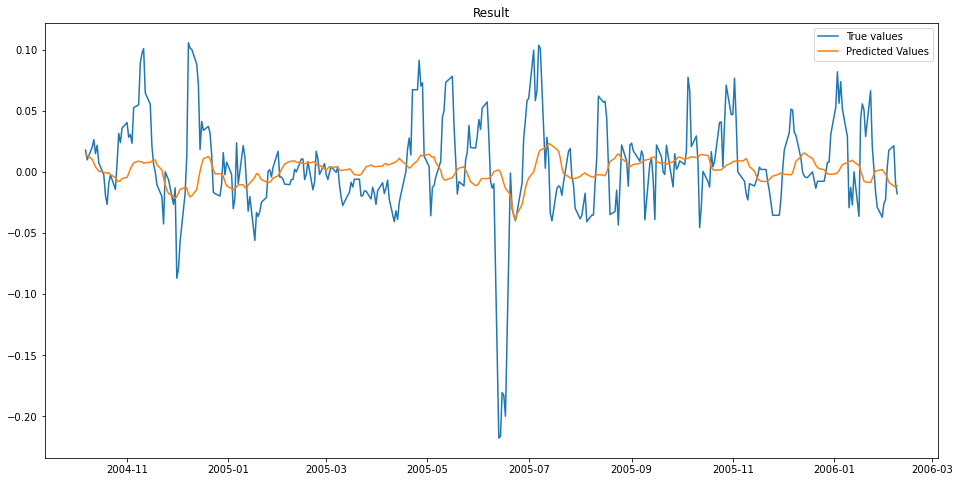


MSE: 0.0017378594667030152

Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 32.2400
Function value obtained: 0.0017
Current minimum: 0.0017
Iteration No: 2 started. Evaluating function at random point.

learning rate: 0.003918194347141745
num_input_nodes: 51
dropout: 0.19492275006819237
sequence_length : 160
batch_size: 112



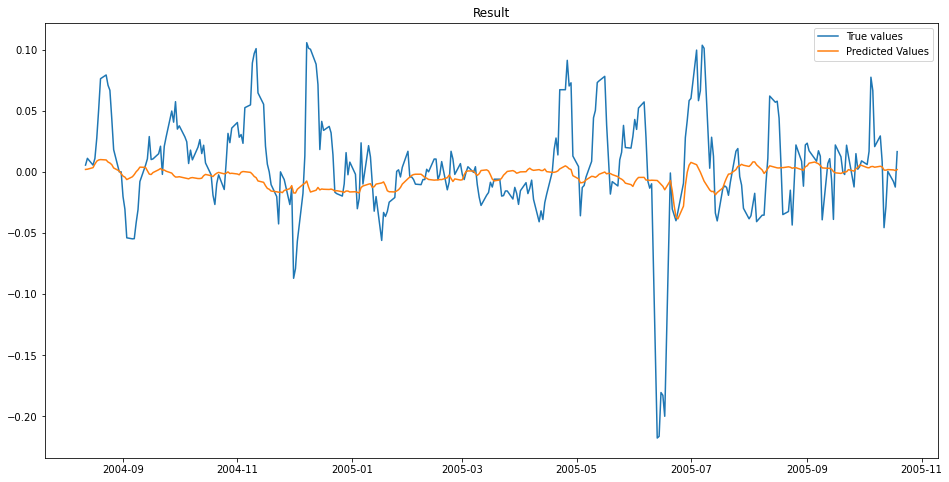


MSE: 0.0018299996639146094

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 13.6574
Function value obtained: 0.0018
Current minimum: 0.0017
Iteration No: 3 started. Evaluating function at random point.

learning rate: 0.00015847101210439096
num_input_nodes: 120
dropout: 0.08342715278475547
sequence_length : 114
batch_size: 163



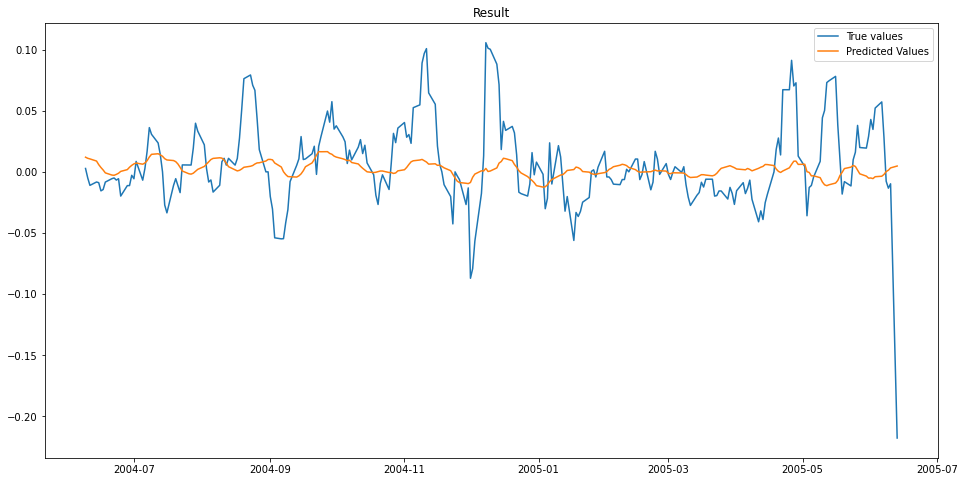


MSE: 0.001201401672377501

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 9.4924
Function value obtained: 0.0012
Current minimum: 0.0012
Iteration No: 4 started. Evaluating function at random point.

learning rate: 0.00012966511753760403
num_input_nodes: 186
dropout: 0.2346381772539376
sequence_length : 100
batch_size: 248



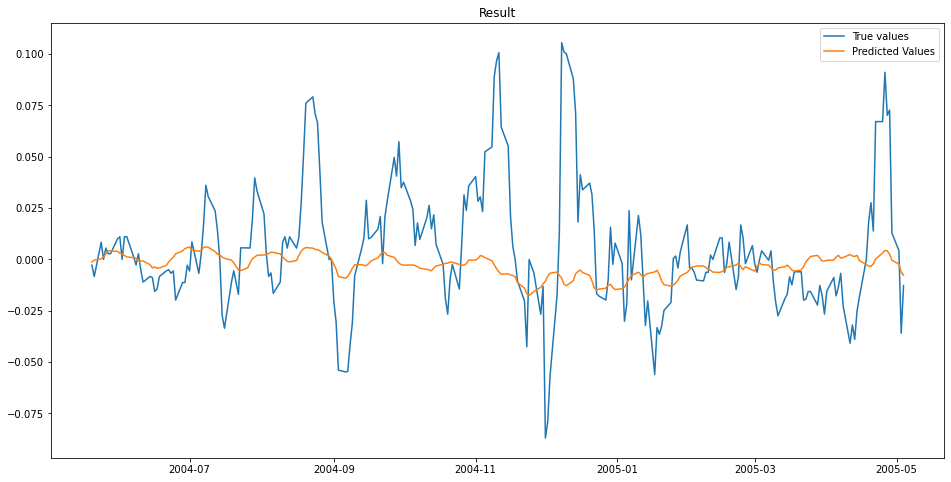


MSE: 0.0009929331213026828

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 12.2395
Function value obtained: 0.0010
Current minimum: 0.0010
Iteration No: 5 started. Evaluating function at random point.

learning rate: 0.0017177621112338384
num_input_nodes: 159
dropout: 0.001766576304929352
sequence_length : 102
batch_size: 132



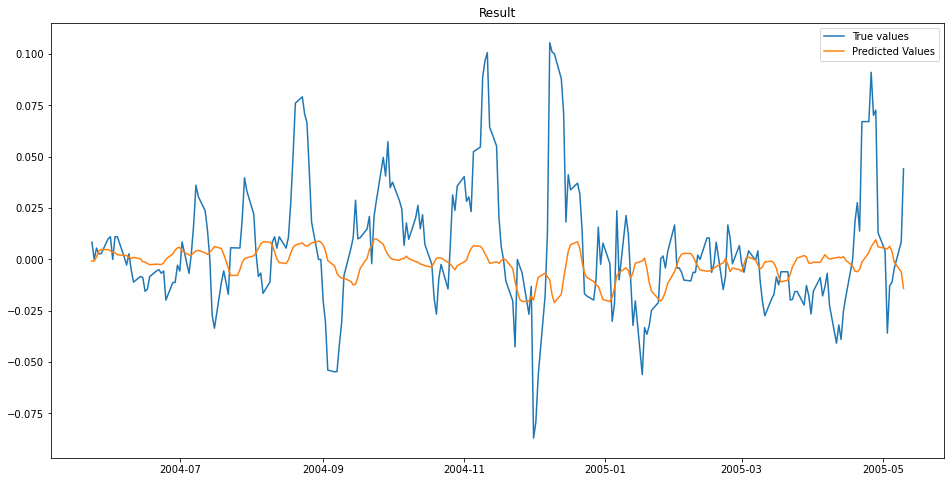


MSE: 0.00097873108974363

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 13.5015
Function value obtained: 0.0010
Current minimum: 0.0010
Iteration No: 6 started. Evaluating function at random point.

learning rate: 0.0006305535040199287
num_input_nodes: 17
dropout: 0.24343887971036485
sequence_length : 123
batch_size: 24



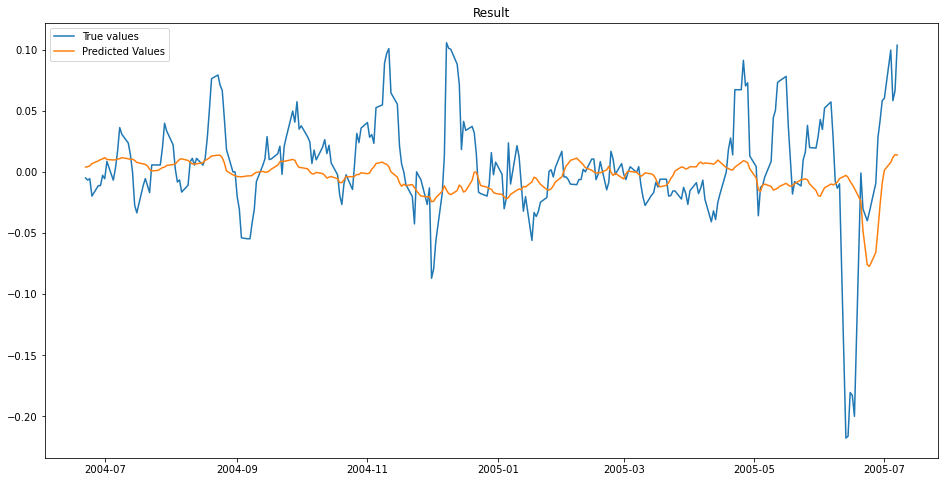


MSE: 0.0019301618489288772

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 31.8683
Function value obtained: 0.0019
Current minimum: 0.0010
Iteration No: 7 started. Evaluating function at random point.

learning rate: 0.0017249321573178998
num_input_nodes: 101
dropout: 0.2458077214516971
sequence_length : 147
batch_size: 215



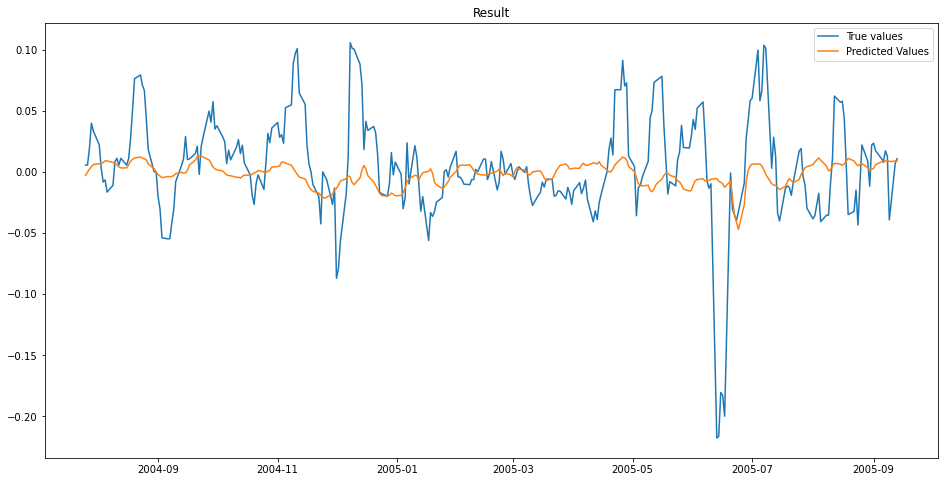


MSE: 0.0018256120477542614

Iteration No: 7 ended. Evaluation done at random point.
Time taken: 11.6902
Function value obtained: 0.0018
Current minimum: 0.0010
Iteration No: 8 started. Evaluating function at random point.

learning rate: 0.0022941144328643983
num_input_nodes: 118
dropout: 0.003316240289966633
sequence_length : 194
batch_size: 141



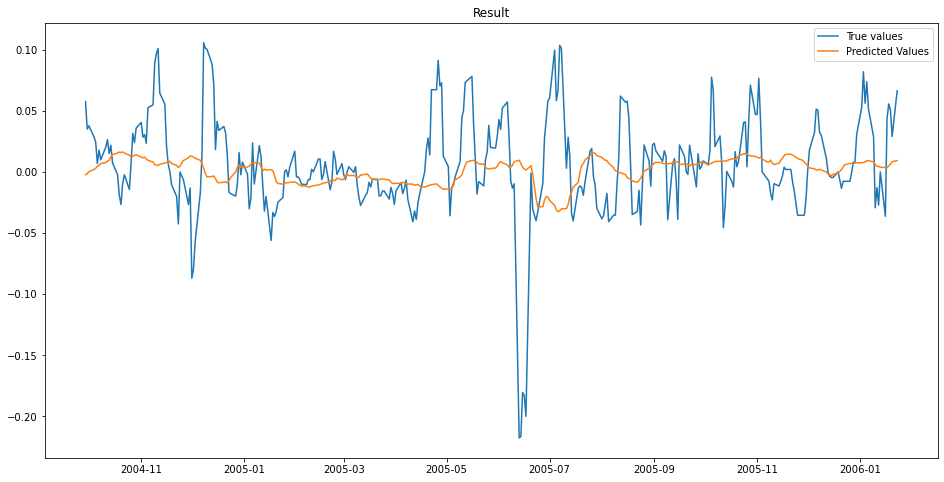


MSE: 0.0019091044123669958

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 15.3890
Function value obtained: 0.0019
Current minimum: 0.0010
Iteration No: 9 started. Evaluating function at random point.

learning rate: 0.0005899741796710488
num_input_nodes: 9
dropout: 0.05772345640553726
sequence_length : 124
batch_size: 171



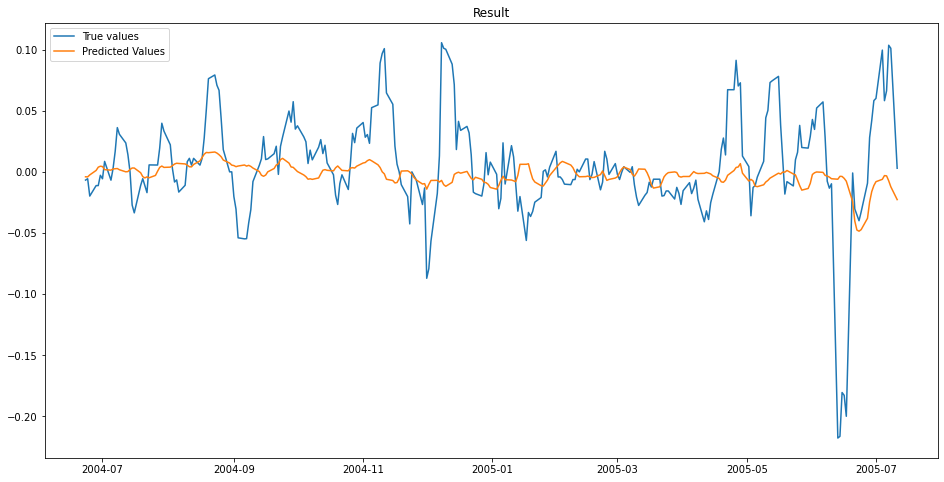


MSE: 0.0019494513692579747

Iteration No: 9 ended. Evaluation done at random point.
Time taken: 16.2580
Function value obtained: 0.0019
Current minimum: 0.0010
Iteration No: 10 started. Evaluating function at random point.

learning rate: 0.0016595613641357258
num_input_nodes: 214
dropout: 0.04334116337694303
sequence_length : 139
batch_size: 46



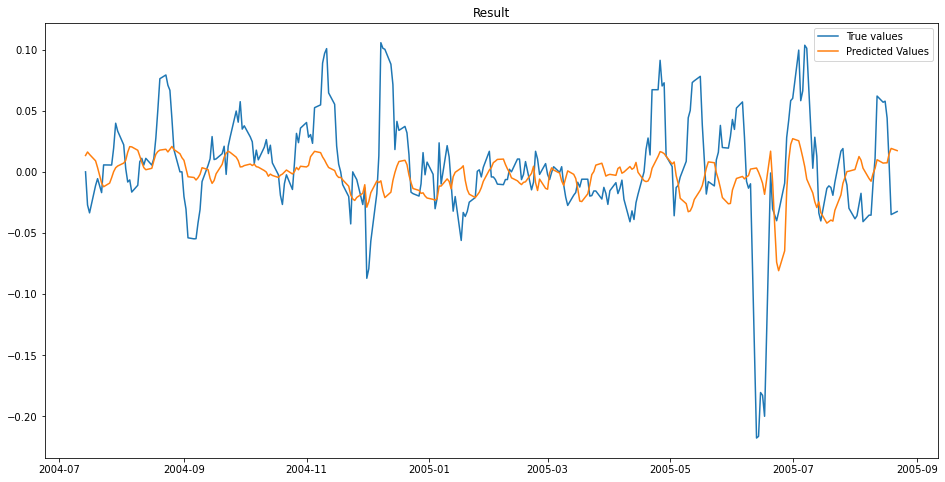


MSE: 0.0019240935256583547

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 30.1827
Function value obtained: 0.0019
Current minimum: 0.0010
Iteration No: 11 started. Evaluating function at random point.

learning rate: 0.0032413268041956303
num_input_nodes: 112
dropout: 0.05198541571704722
sequence_length : 157
batch_size: 9



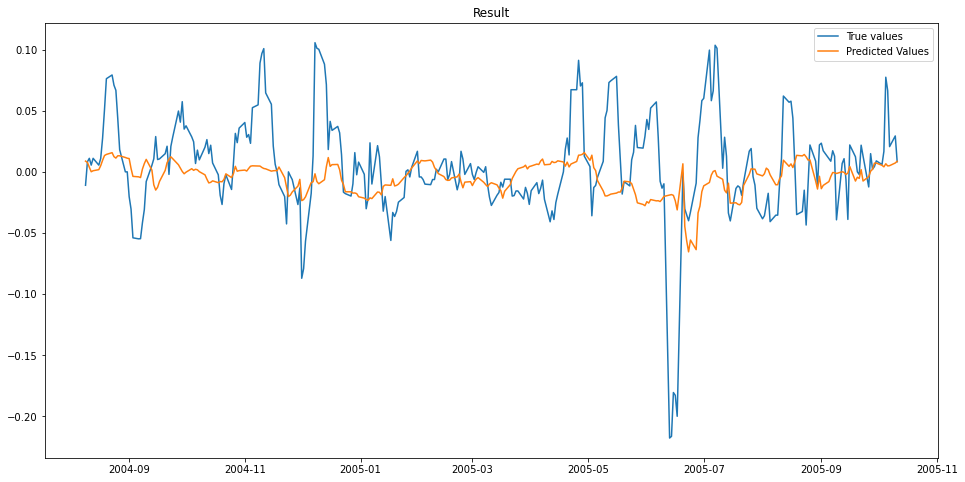


MSE: 0.0018287963116127908

Iteration No: 11 ended. Evaluation done at random point.
Time taken: 56.1429
Function value obtained: 0.0018
Current minimum: 0.0010
Iteration No: 12 started. Evaluating function at random point.

learning rate: 0.004836927180682221
num_input_nodes: 227
dropout: 0.18507824608274567
sequence_length : 163
batch_size: 20



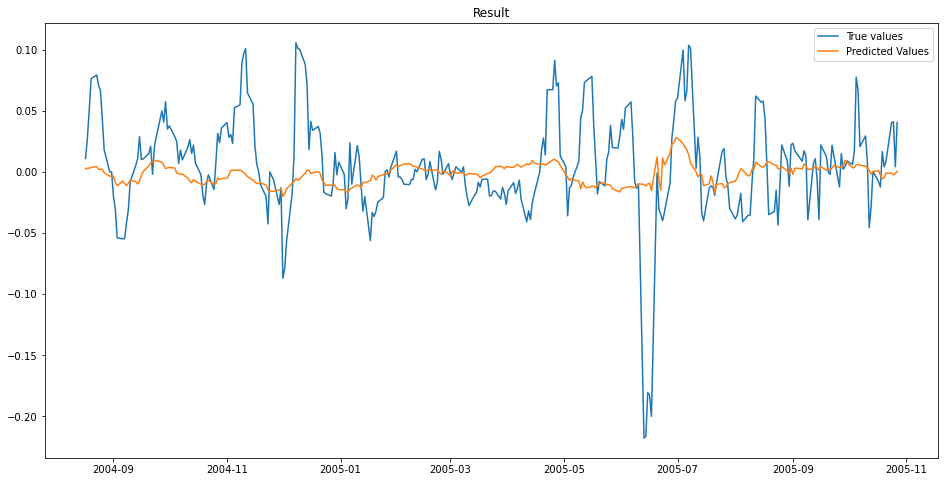


MSE: 0.0017398618108377892

Iteration No: 12 ended. Evaluation done at random point.
Time taken: 60.0677
Function value obtained: 0.0017
Current minimum: 0.0010
Iteration No: 13 started. Searching for the next optimal point.

learning rate: 0.0011055354209093056
num_input_nodes: 247
dropout: 0.23961521562344856
sequence_length : 105
batch_size: 66



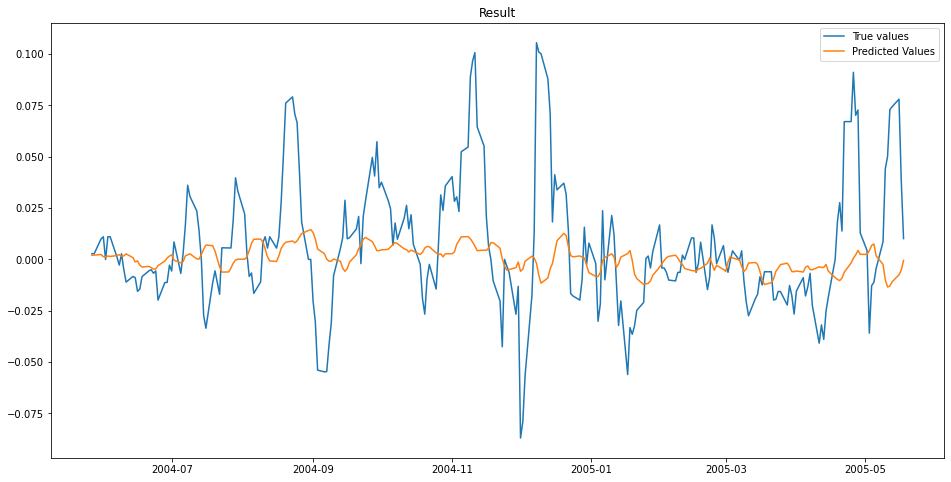


MSE: 0.0010356565032811622

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 20.0010
Function value obtained: 0.0010
Current minimum: 0.0010
Iteration No: 14 started. Searching for the next optimal point.

learning rate: 0.0002050670804560787
num_input_nodes: 240
dropout: 0.23434029225351388
sequence_length : 141
batch_size: 44



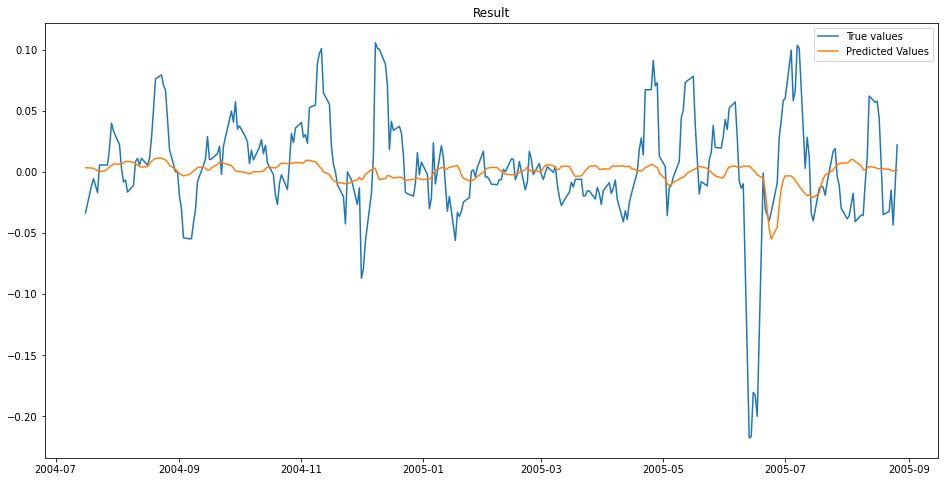


MSE: 0.0019368247889984492

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 20.5154
Function value obtained: 0.0019
Current minimum: 0.0010
Iteration No: 15 started. Searching for the next optimal point.

learning rate: 0.00010993676976866407
num_input_nodes: 98
dropout: 0.19810399992331712
sequence_length : 151
batch_size: 140



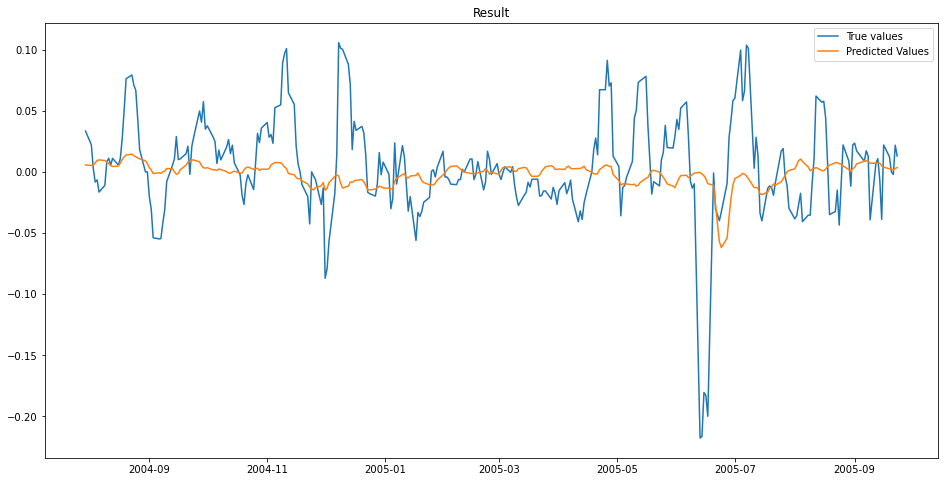


MSE: 0.0018831910069198638

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 17.7456
Function value obtained: 0.0019
Current minimum: 0.0010
Iteration No: 16 started. Searching for the next optimal point.

learning rate: 0.0001040887456555644
num_input_nodes: 228
dropout: 0.1383620356395441
sequence_length : 150
batch_size: 41



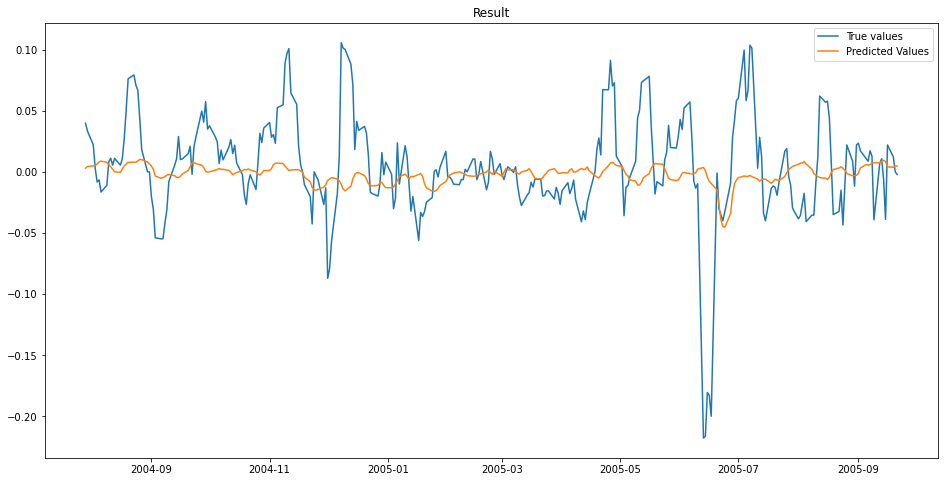


MSE: 0.0018961391906078561

Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 21.1742
Function value obtained: 0.0019
Current minimum: 0.0010
Iteration No: 17 started. Searching for the next optimal point.

learning rate: 0.0028432579235393727
num_input_nodes: 172
dropout: 0.006246422829997629
sequence_length : 198
batch_size: 119



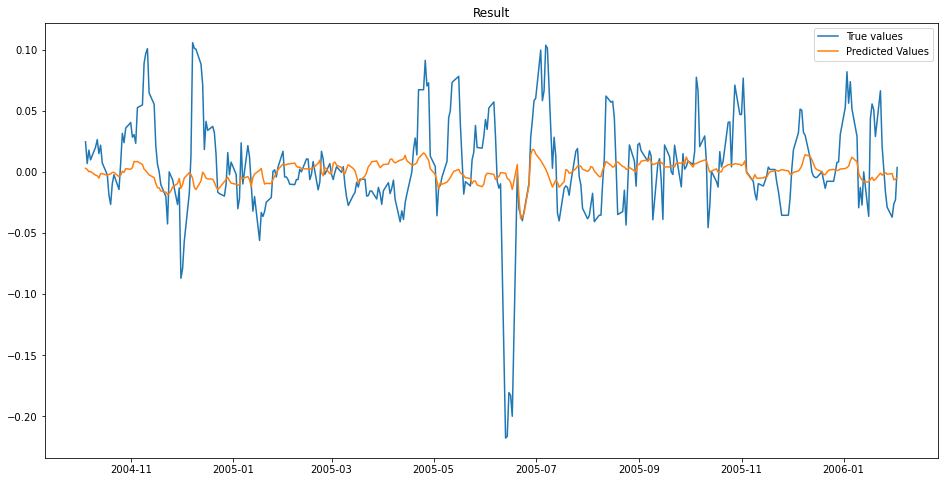


MSE: 0.0016348012190591386

Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 15.1237
Function value obtained: 0.0016
Current minimum: 0.0010
Iteration No: 18 started. Searching for the next optimal point.

learning rate: 0.01
num_input_nodes: 190
dropout: 0.22948640320327152
sequence_length : 100
batch_size: 225



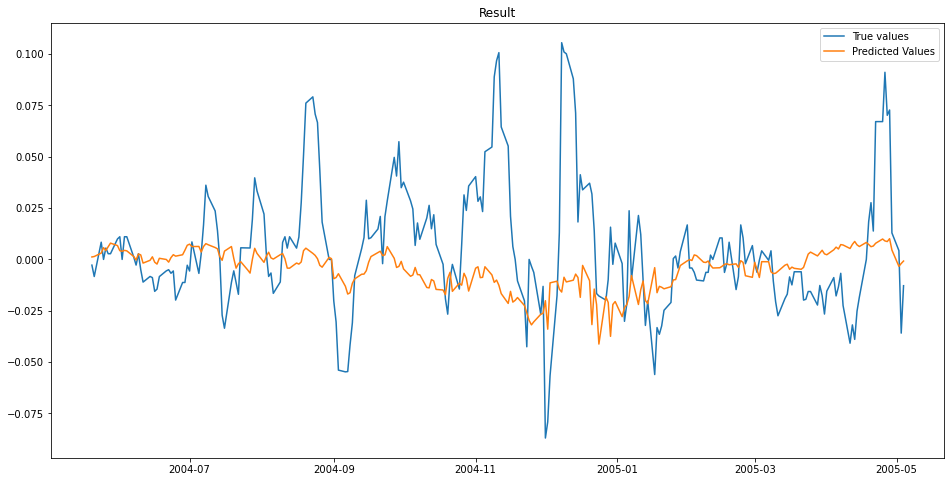


MSE: 0.0010794337358171994

Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 11.8365
Function value obtained: 0.0011
Current minimum: 0.0010
Iteration No: 19 started. Searching for the next optimal point.

learning rate: 0.0001
num_input_nodes: 69
dropout: 0.0
sequence_length : 105
batch_size: 217



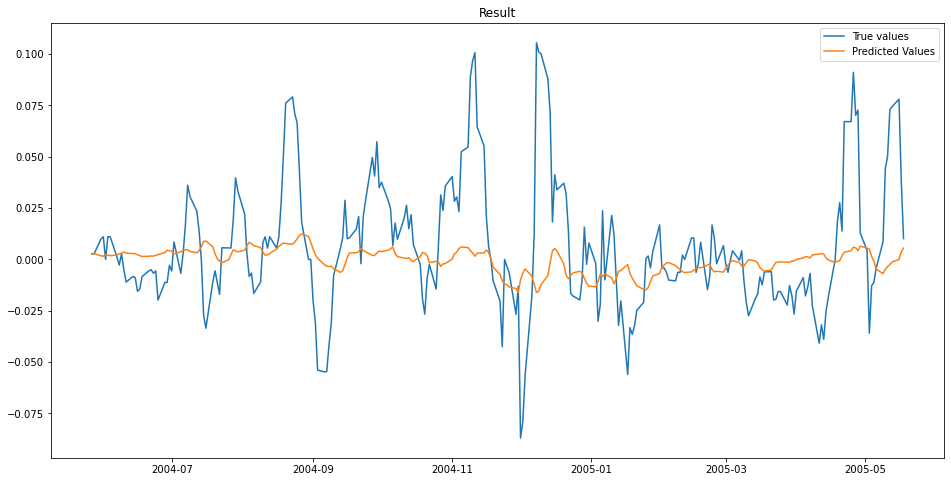


MSE: 0.0010275491539726623

Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 11.7647
Function value obtained: 0.0010
Current minimum: 0.0010
Iteration No: 20 started. Searching for the next optimal point.

learning rate: 0.00030709853192148267
num_input_nodes: 112
dropout: 0.24704036809217153
sequence_length : 102
batch_size: 59



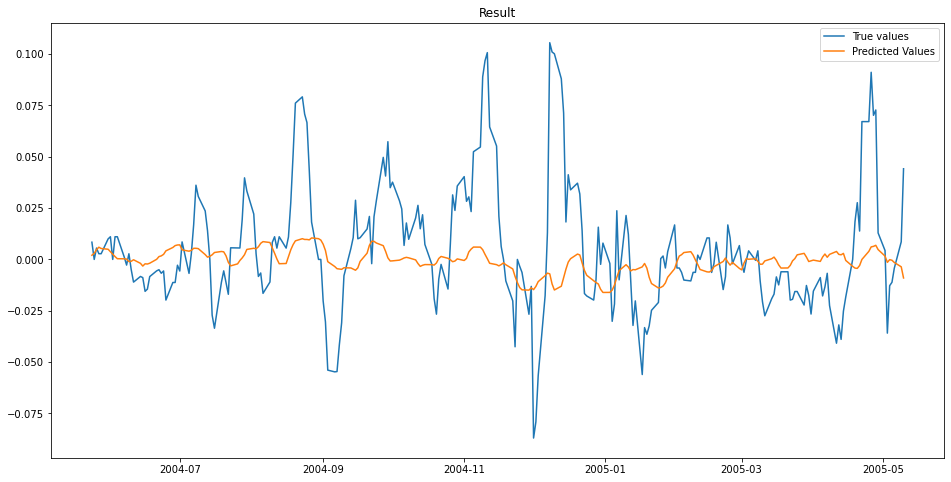


MSE: 0.0009531795312043771

Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 12.2201
Function value obtained: 0.0010
Current minimum: 0.0010
Iteration No: 21 started. Searching for the next optimal point.

learning rate: 0.0001
num_input_nodes: 211
dropout: 0.02808629198404091
sequence_length : 102
batch_size: 170



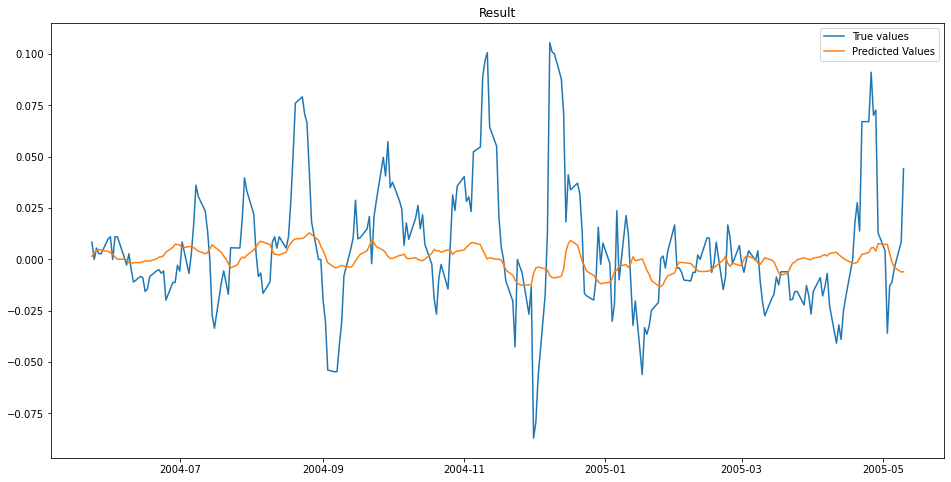


MSE: 0.000932320789072044

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 13.8946
Function value obtained: 0.0009
Current minimum: 0.0009
Iteration No: 22 started. Searching for the next optimal point.

learning rate: 0.01
num_input_nodes: 221
dropout: 0.2236879292425917
sequence_length : 110
batch_size: 225



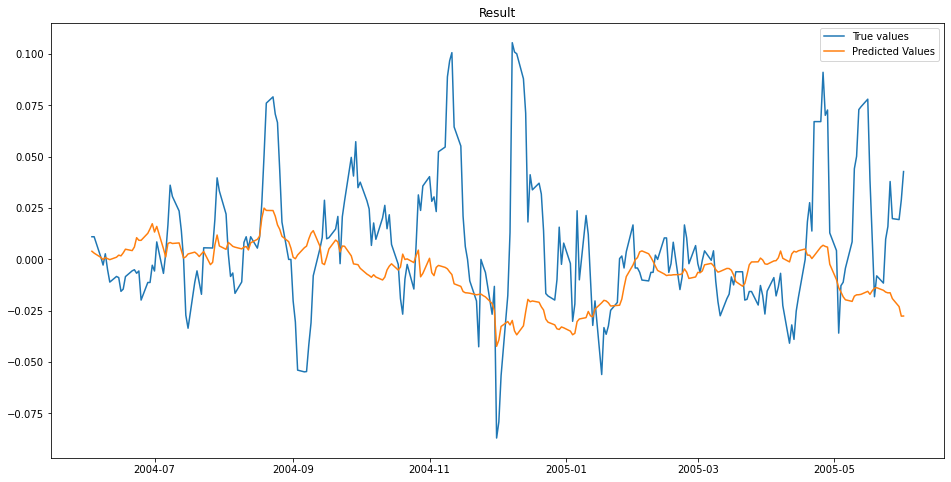


MSE: 0.0012998792013051753

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 15.1760
Function value obtained: 0.0013
Current minimum: 0.0009
Iteration No: 23 started. Searching for the next optimal point.

learning rate: 0.000103924815699089
num_input_nodes: 8
dropout: 0.09718240199686376
sequence_length : 178
batch_size: 82



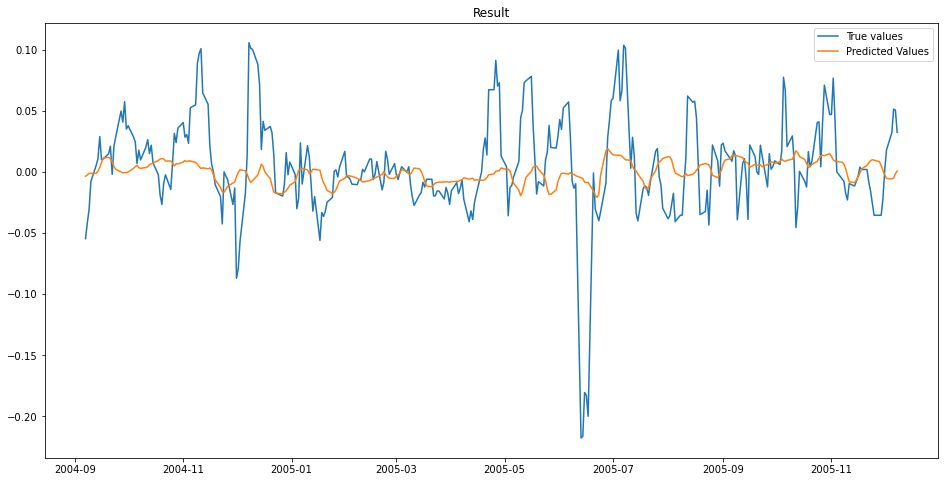


MSE: 0.0016912562053478404

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 18.8648
Function value obtained: 0.0017
Current minimum: 0.0009
Iteration No: 24 started. Searching for the next optimal point.

learning rate: 0.0001
num_input_nodes: 233
dropout: 0.12868030117095594
sequence_length : 103
batch_size: 36



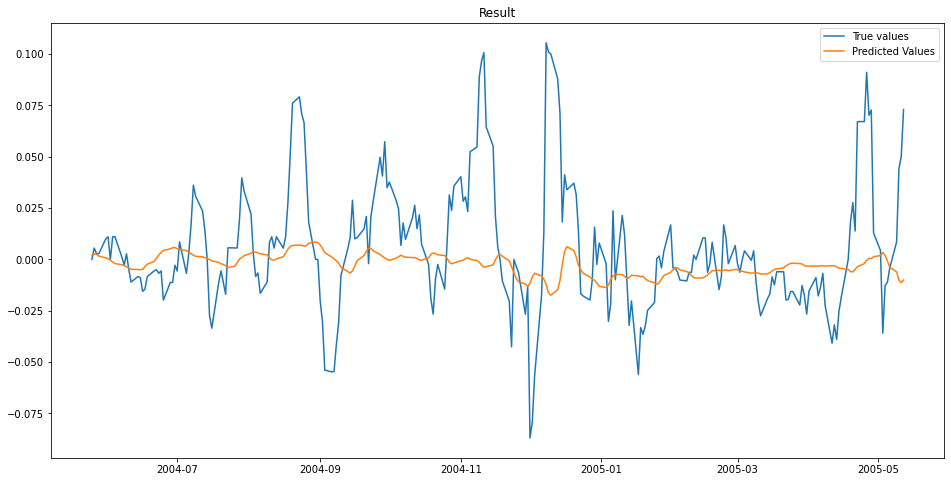


MSE: 0.0010433796734633214

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 26.0235
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 25 started. Searching for the next optimal point.

learning rate: 0.0002858844098343165
num_input_nodes: 124
dropout: 0.19871927528155914
sequence_length : 112
batch_size: 17



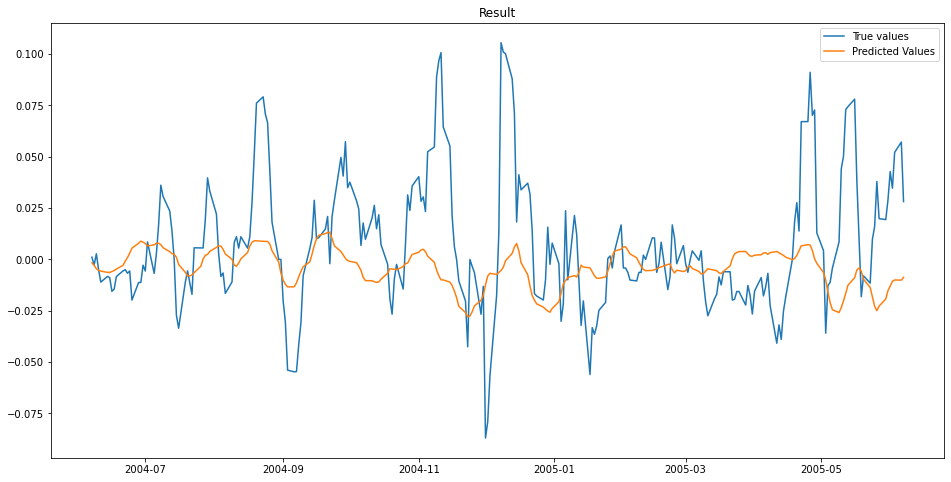


MSE: 0.0011425323736231237

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 22.5727
Function value obtained: 0.0011
Current minimum: 0.0009
Iteration No: 26 started. Searching for the next optimal point.

learning rate: 0.0004568754032414632
num_input_nodes: 12
dropout: 0.07344784690643444
sequence_length : 100
batch_size: 241



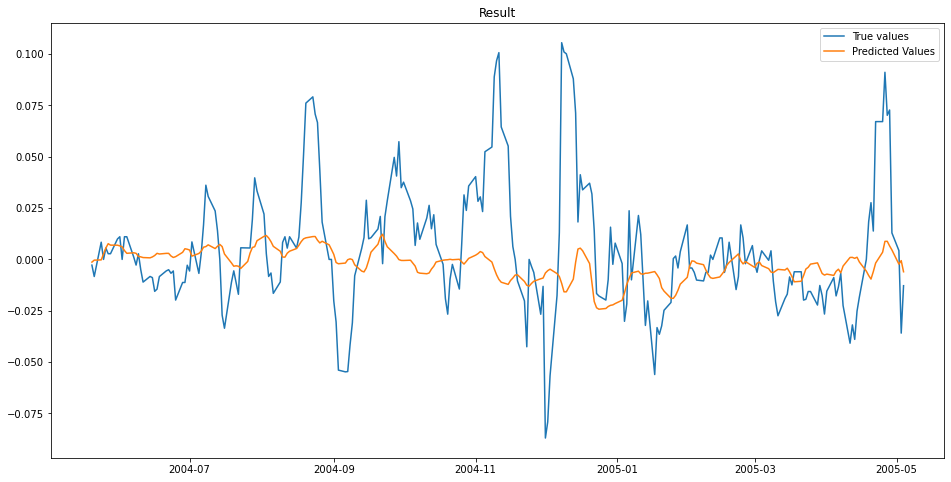


MSE: 0.000995026990281953

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 12.7800
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 27 started. Searching for the next optimal point.

learning rate: 0.00391989751341379
num_input_nodes: 67
dropout: 0.22209883733973426
sequence_length : 161
batch_size: 144



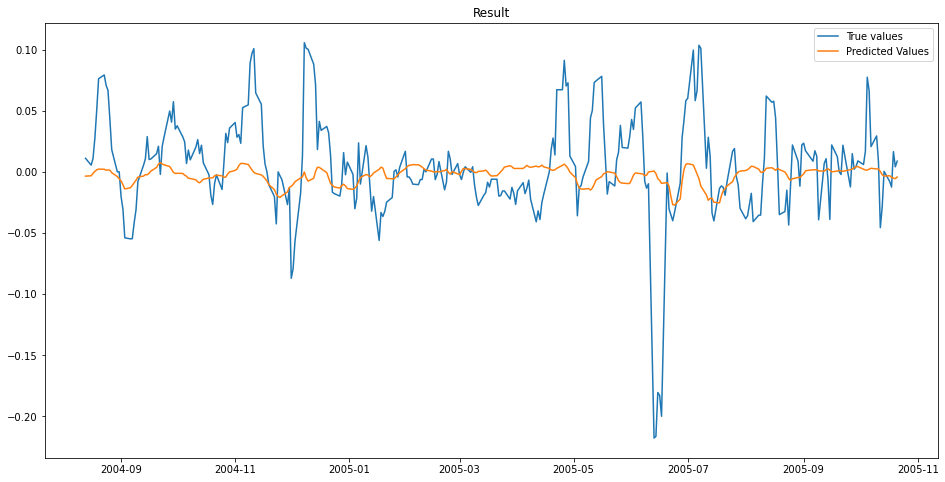


MSE: 0.0018271037505975254

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 12.3661
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 28 started. Searching for the next optimal point.

learning rate: 0.0022506529857244336
num_input_nodes: 161
dropout: 0.08522162464234627
sequence_length : 155
batch_size: 198



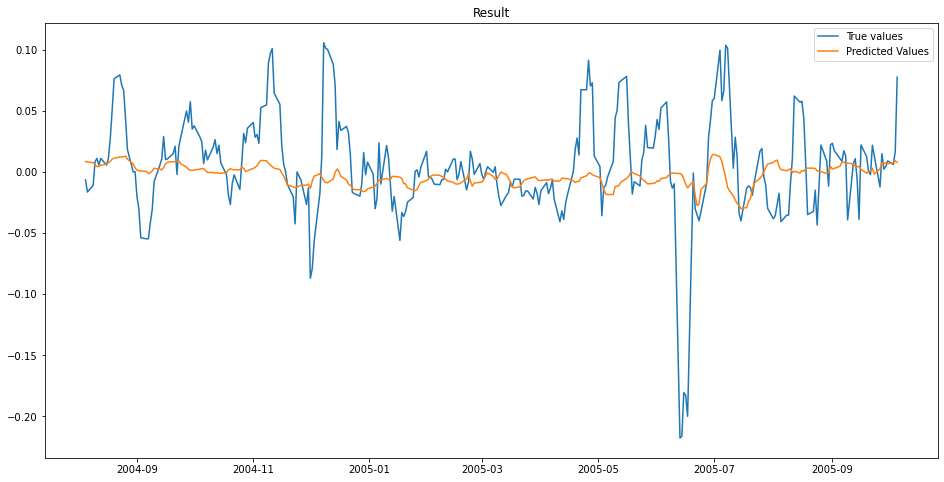


MSE: 0.0018005552290343337

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 17.3463
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 29 started. Searching for the next optimal point.

learning rate: 0.00043407796537720076
num_input_nodes: 207
dropout: 0.05111844448881574
sequence_length : 187
batch_size: 195



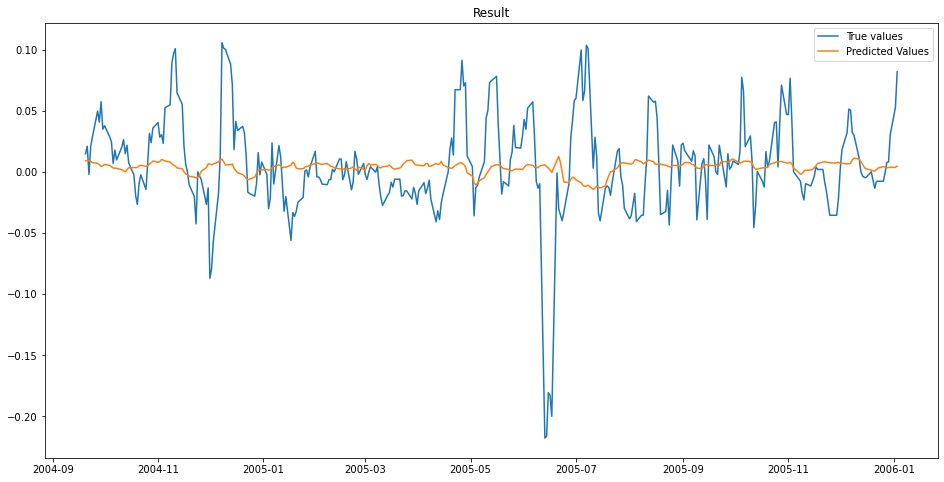


MSE: 0.0017281715186604762

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 17.0521
Function value obtained: 0.0017
Current minimum: 0.0009
Iteration No: 30 started. Searching for the next optimal point.

learning rate: 0.0020071857054210717
num_input_nodes: 53
dropout: 0.15903945320548288
sequence_length : 110
batch_size: 151



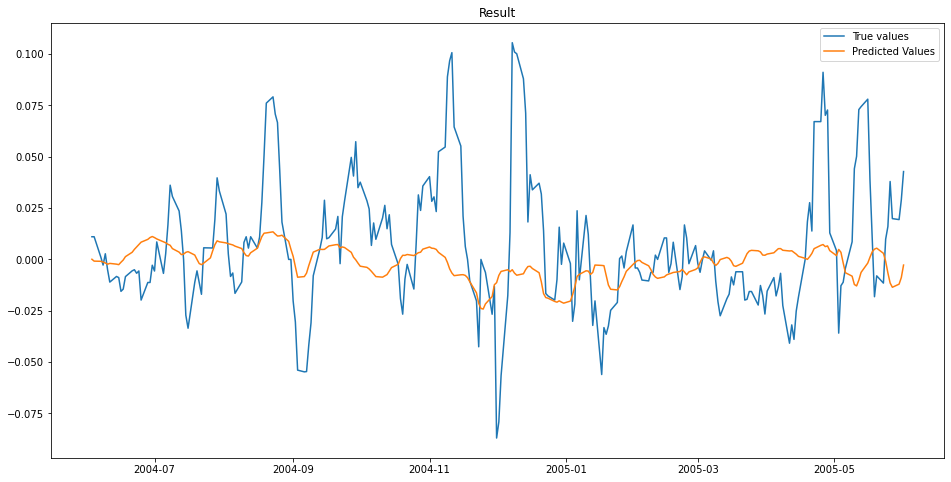


MSE: 0.0010713419797742398

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 10.1574
Function value obtained: 0.0011
Current minimum: 0.0009
Iteration No: 31 started. Searching for the next optimal point.

learning rate: 0.0017560590100163395
num_input_nodes: 197
dropout: 0.1088747643186341
sequence_length : 121
batch_size: 65



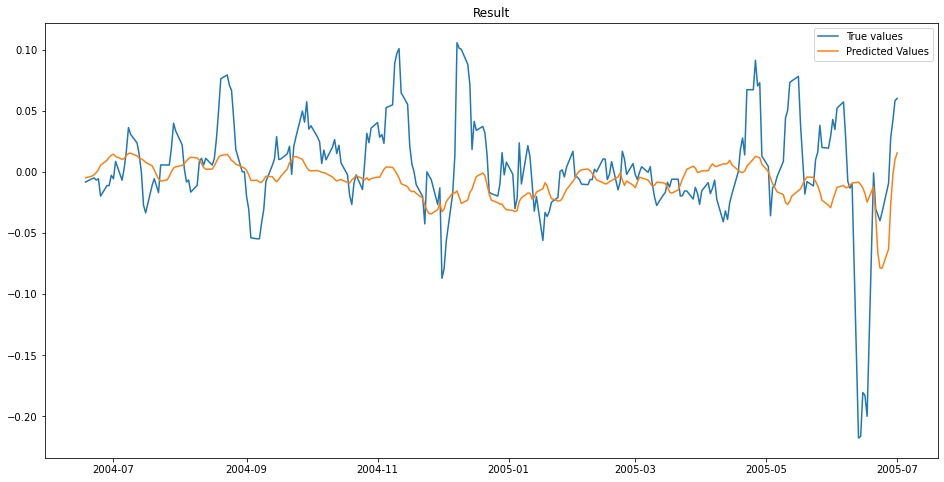


MSE: 0.001885434488045563

Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 22.2501
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 32 started. Searching for the next optimal point.

learning rate: 0.0008633902007401385
num_input_nodes: 127
dropout: 0.008028454523932834
sequence_length : 176
batch_size: 126



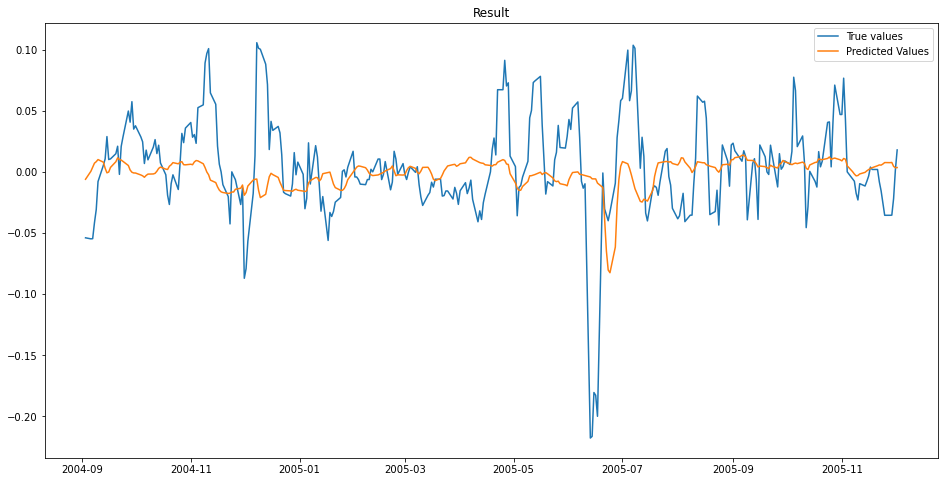


MSE: 0.001782397716842026

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 17.9358
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 33 started. Searching for the next optimal point.

learning rate: 0.0003125732810502738
num_input_nodes: 52
dropout: 0.11887285405944947
sequence_length : 158
batch_size: 179



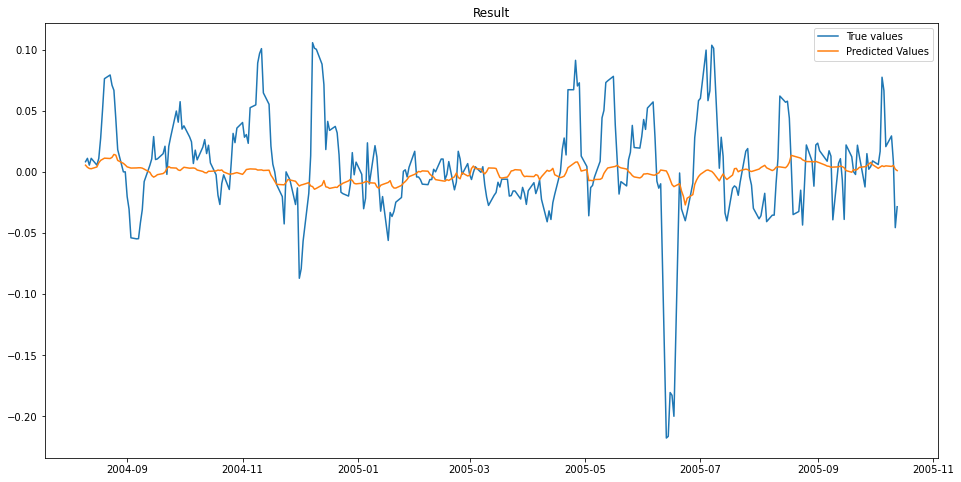


MSE: 0.0018185312901285808

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 11.2618
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 34 started. Searching for the next optimal point.

learning rate: 0.00022184183289896374
num_input_nodes: 96
dropout: 0.011921636836763397
sequence_length : 129
batch_size: 205



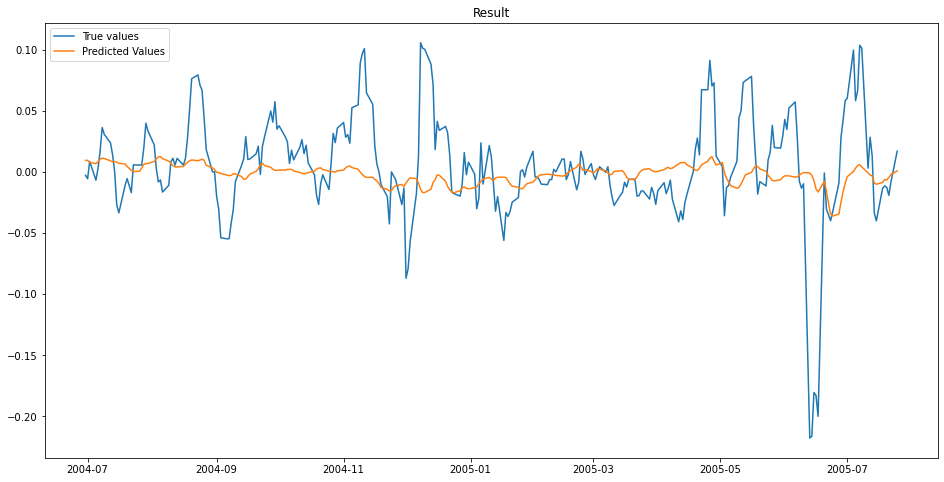


MSE: 0.001889829573844362

Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 10.3309
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 35 started. Searching for the next optimal point.

learning rate: 0.00042280590565688304
num_input_nodes: 251
dropout: 0.10488889440285293
sequence_length : 100
batch_size: 63



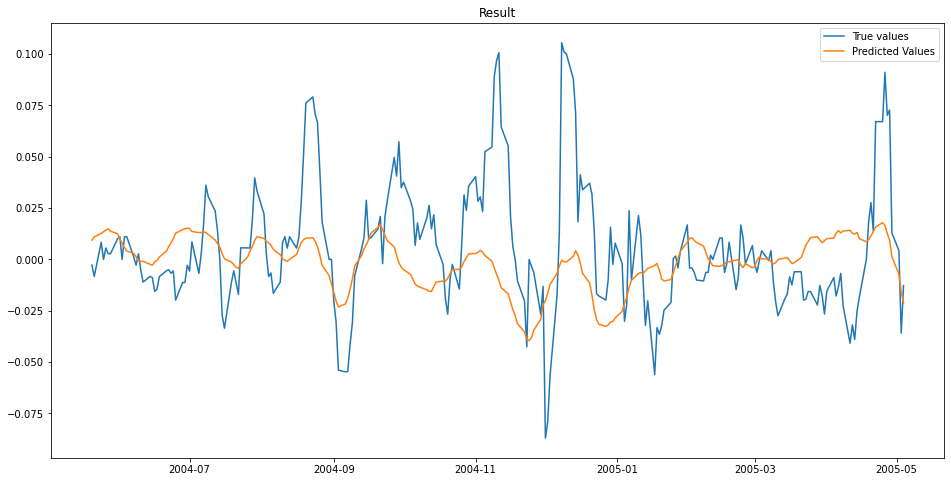


MSE: 0.0009898892938098268

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 19.8934
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 36 started. Searching for the next optimal point.

learning rate: 0.0005533618018103925
num_input_nodes: 41
dropout: 0.008490204283197886
sequence_length : 102
batch_size: 249



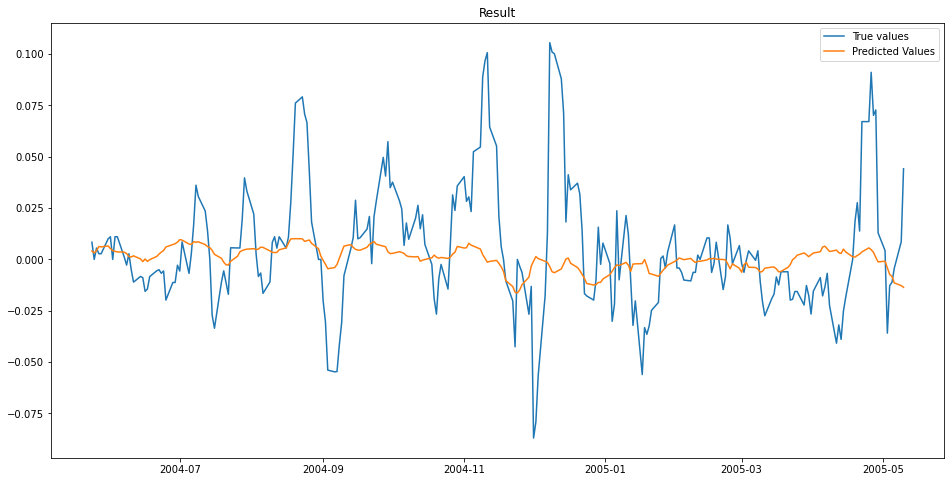


MSE: 0.0009324048908915492

Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 9.4268
Function value obtained: 0.0009
Current minimum: 0.0009
Iteration No: 37 started. Searching for the next optimal point.

learning rate: 0.0008798677566889256
num_input_nodes: 5
dropout: 0.08090095230163441
sequence_length : 103
batch_size: 240



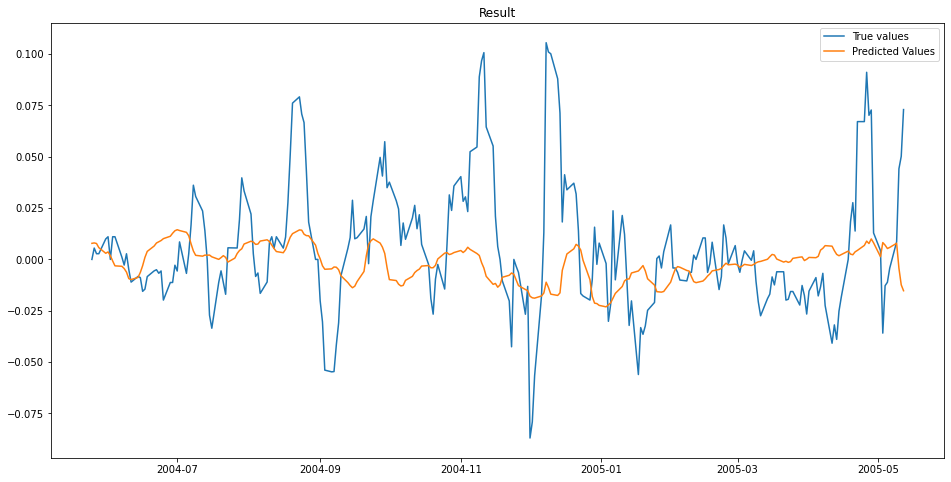


MSE: 0.0010456735347899998

Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 16.5010
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 38 started. Searching for the next optimal point.

learning rate: 0.001385168775294796
num_input_nodes: 149
dropout: 0.04594948359045937
sequence_length : 114
batch_size: 57



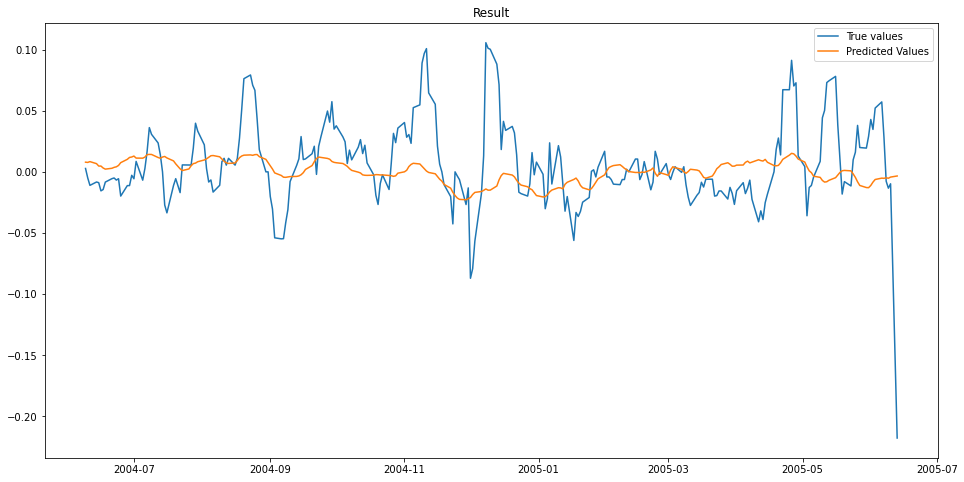


MSE: 0.0012370311158819926

Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 18.6795
Function value obtained: 0.0012
Current minimum: 0.0009
Iteration No: 39 started. Searching for the next optimal point.

learning rate: 0.008510984339216363
num_input_nodes: 6
dropout: 0.05192338510125548
sequence_length : 118
batch_size: 2



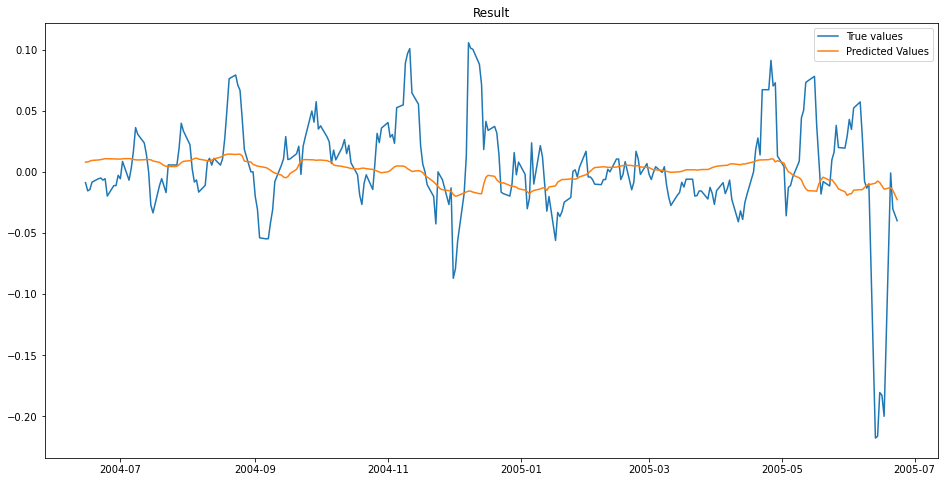


MSE: 0.0017863408390131985

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 101.4173
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 40 started. Searching for the next optimal point.

learning rate: 0.00025023919664219615
num_input_nodes: 244
dropout: 0.1194401150232195
sequence_length : 114
batch_size: 166



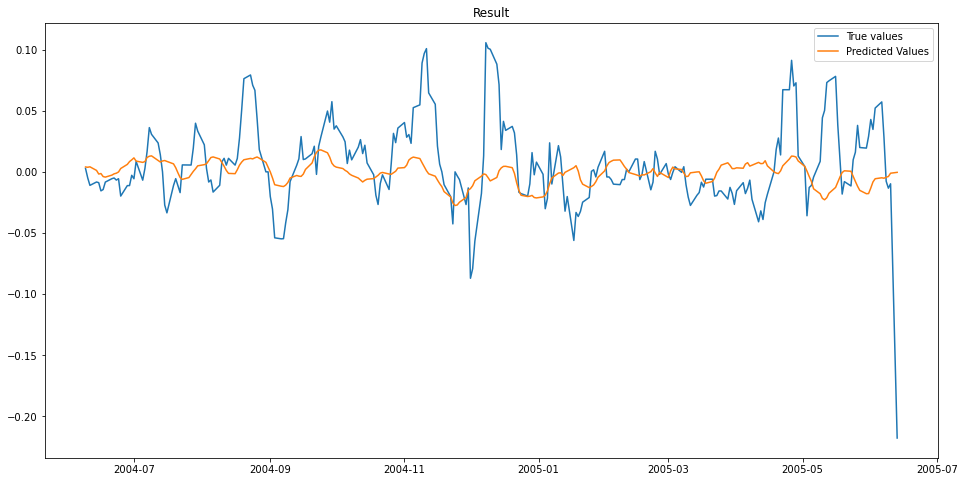


MSE: 0.0012485638350224616

Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 14.6655
Function value obtained: 0.0012
Current minimum: 0.0009
Iteration No: 41 started. Searching for the next optimal point.

learning rate: 0.0006916911497906814
num_input_nodes: 142
dropout: 0.18595234380023104
sequence_length : 166
batch_size: 109



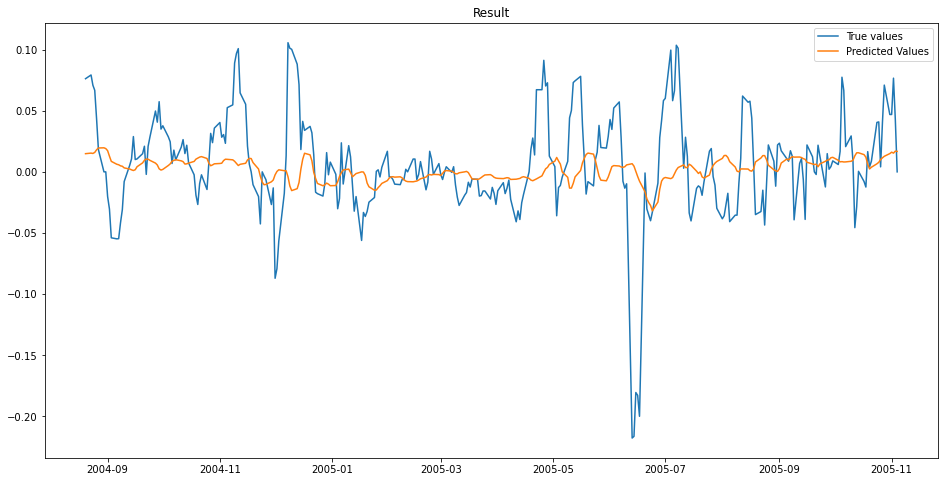


MSE: 0.0018772800898329653

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 16.1058
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 42 started. Searching for the next optimal point.

learning rate: 0.006257393327206118
num_input_nodes: 86
dropout: 0.12898899378067608
sequence_length : 178
batch_size: 185



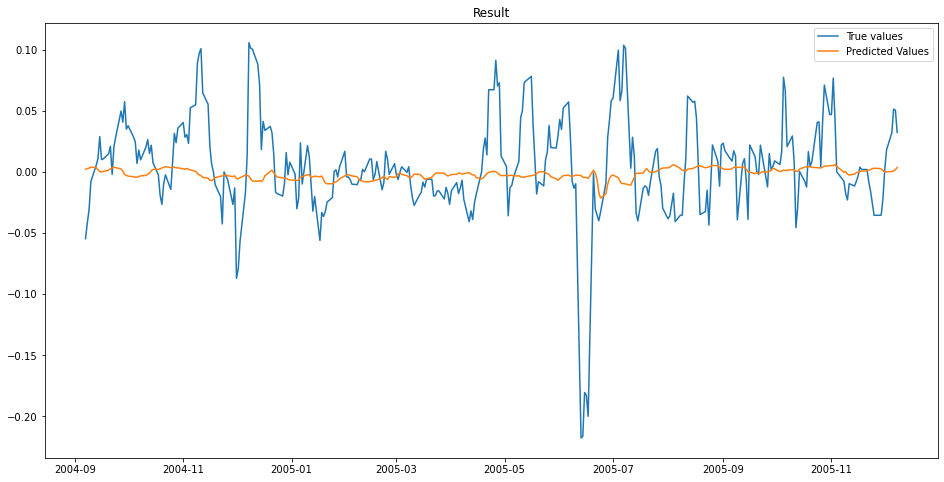


MSE: 0.0017902386844856845

Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 12.4566
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 43 started. Searching for the next optimal point.

learning rate: 0.0001
num_input_nodes: 189
dropout: 0.14108377045966491
sequence_length : 100
batch_size: 142



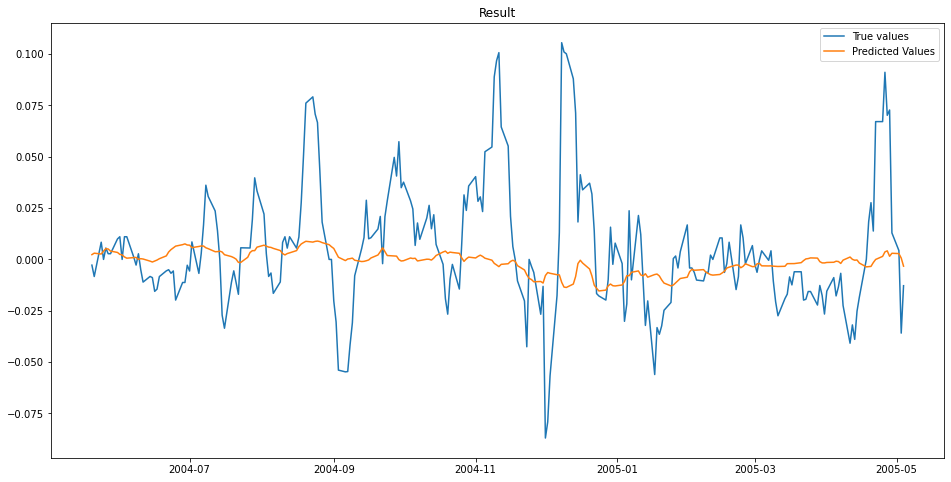


MSE: 0.0009865996665391792

Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 17.1522
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 44 started. Searching for the next optimal point.

learning rate: 0.00015999394011370437
num_input_nodes: 181
dropout: 0.08604513919744848
sequence_length : 110
batch_size: 34



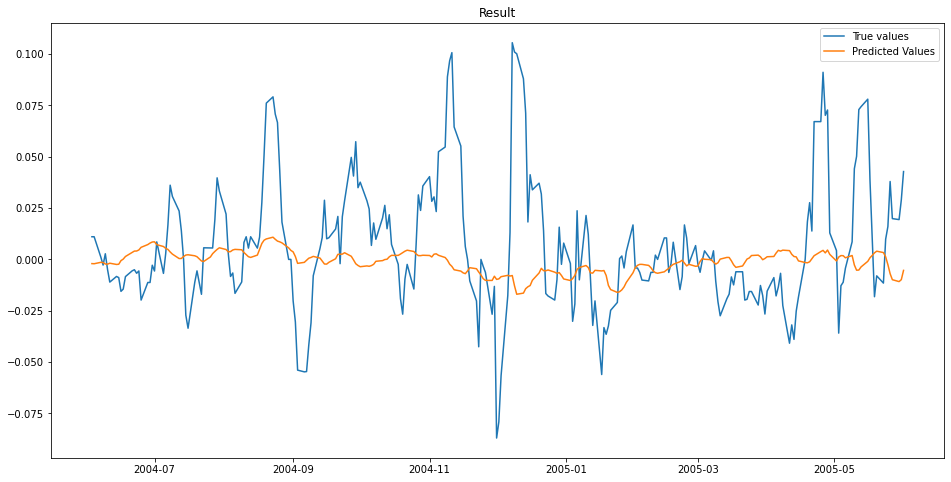


MSE: 0.0010977510527797798

Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 28.8809
Function value obtained: 0.0011
Current minimum: 0.0009
Iteration No: 45 started. Searching for the next optimal point.

learning rate: 0.002576050711952346
num_input_nodes: 217
dropout: 0.18008333534734158
sequence_length : 187
batch_size: 33



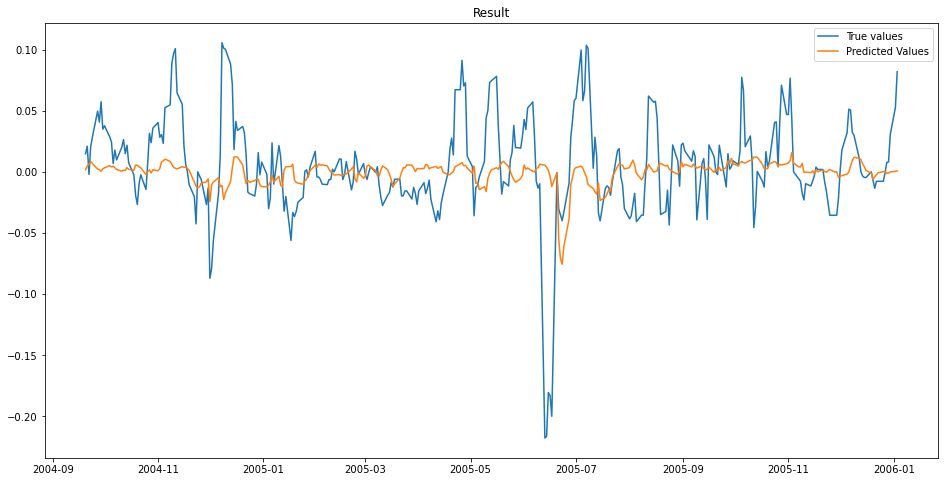


MSE: 0.0017112775894410589

Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 47.4023
Function value obtained: 0.0017
Current minimum: 0.0009
Iteration No: 46 started. Searching for the next optimal point.

learning rate: 0.0036879818841733195
num_input_nodes: 88
dropout: 0.24555595662566815
sequence_length : 165
batch_size: 41



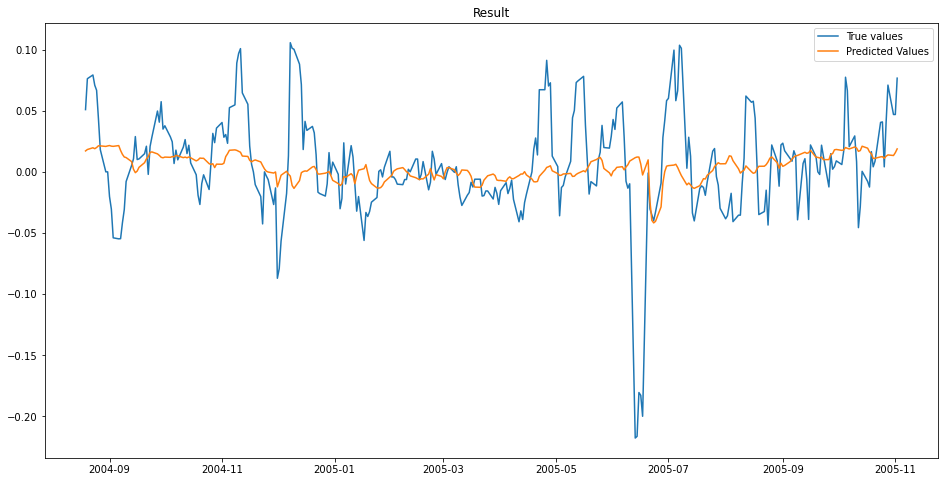


MSE: 0.0018460701371316272

Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 16.4858
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 47 started. Searching for the next optimal point.

learning rate: 0.00011635407776633327
num_input_nodes: 92
dropout: 0.19701404602314318
sequence_length : 157
batch_size: 26



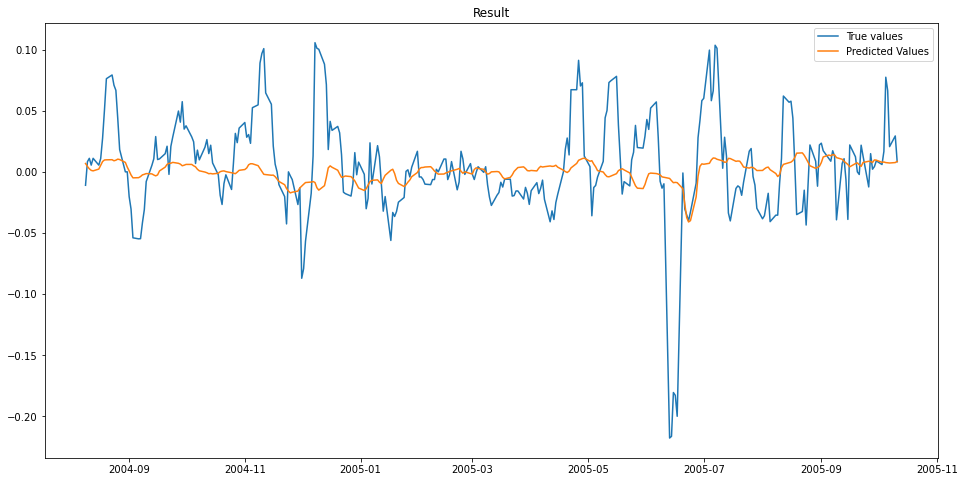


MSE: 0.0017639702354213087

Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 20.7013
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 48 started. Searching for the next optimal point.

learning rate: 0.00098393071892428
num_input_nodes: 216
dropout: 0.0919402180489166
sequence_length : 168
batch_size: 52



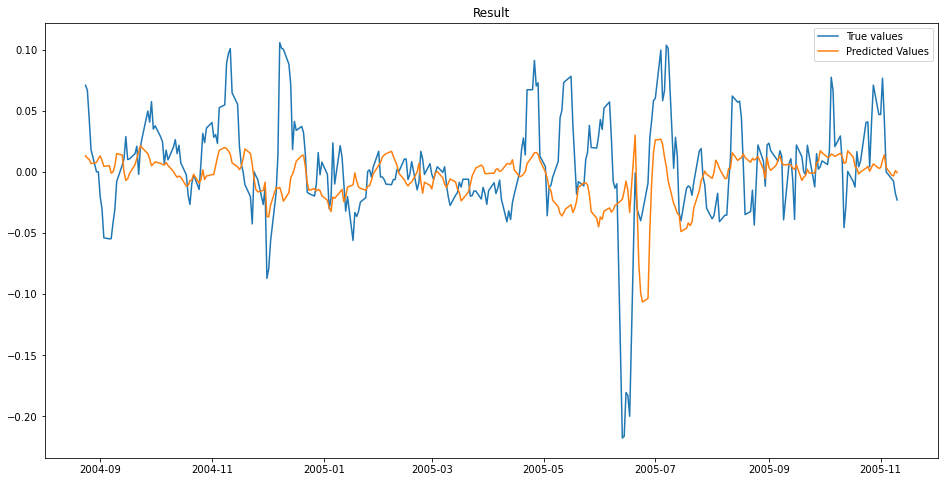


MSE: 0.0018915310651122829

Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 25.0644
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 49 started. Searching for the next optimal point.

learning rate: 0.0005144369147291252
num_input_nodes: 145
dropout: 0.23233057278536348
sequence_length : 100
batch_size: 249



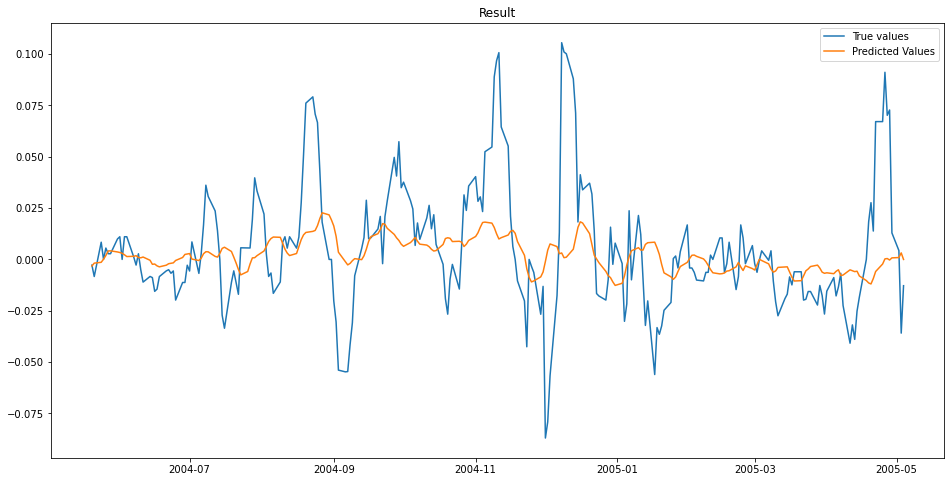


MSE: 0.0008511236385922842

Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 10.8971
Function value obtained: 0.0009
Current minimum: 0.0009
Iteration No: 50 started. Searching for the next optimal point.

learning rate: 0.0015196648522700794
num_input_nodes: 144
dropout: 0.12923914683506915
sequence_length : 107
batch_size: 181



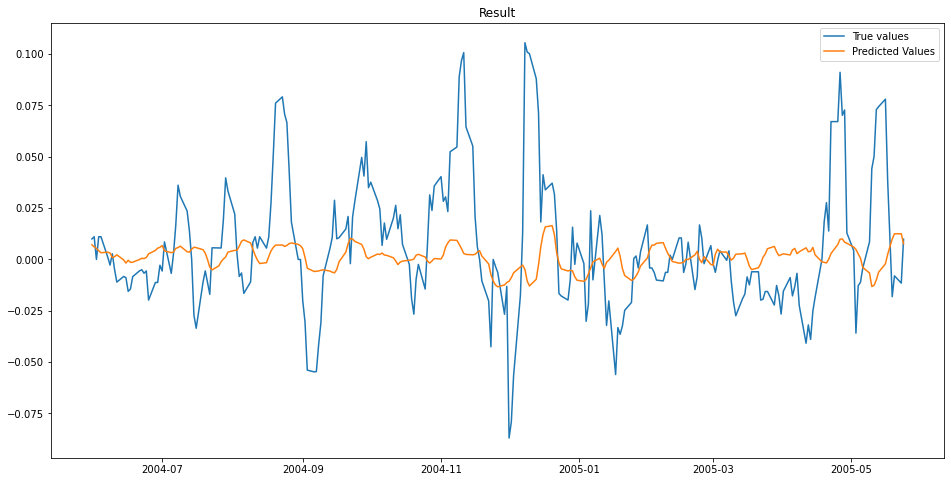


MSE: 0.0010188257302621265

Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 9.9934
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 51 started. Searching for the next optimal point.

learning rate: 0.00035696221331054826
num_input_nodes: 60
dropout: 0.15871059674378532
sequence_length : 152
batch_size: 205



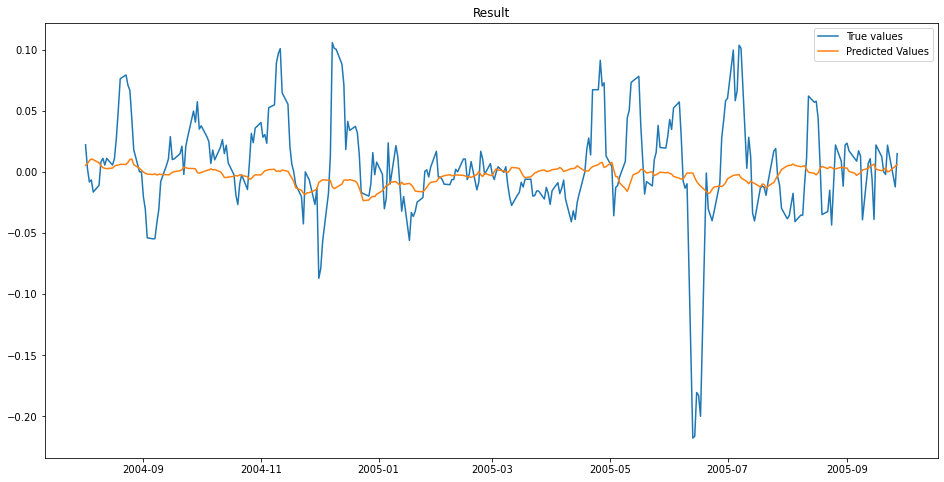


MSE: 0.0018666165678299087

Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 9.9476
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 52 started. Searching for the next optimal point.

learning rate: 0.0001188409223381412
num_input_nodes: 177
dropout: 0.21891156143998414
sequence_length : 168
batch_size: 175



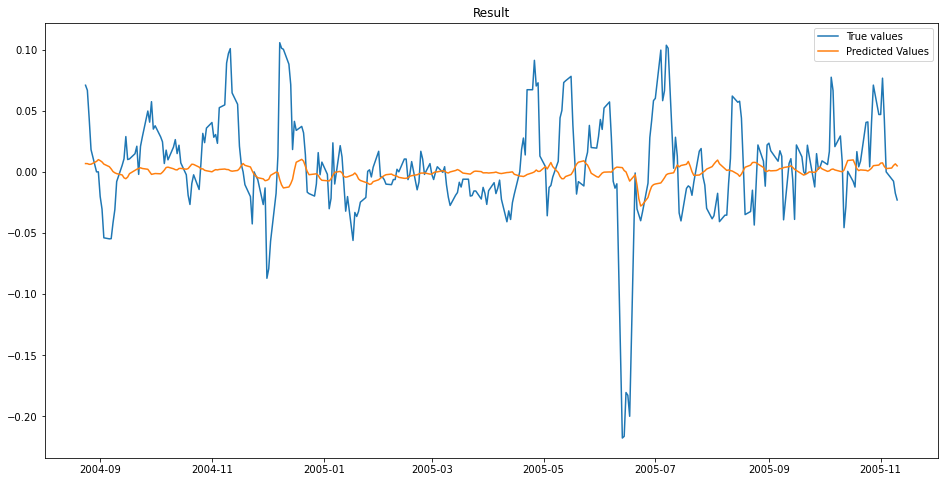


MSE: 0.0018912040604843327

Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 17.0523
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 53 started. Searching for the next optimal point.

learning rate: 0.0033298625298422277
num_input_nodes: 48
dropout: 0.19978580796758103
sequence_length : 124
batch_size: 174



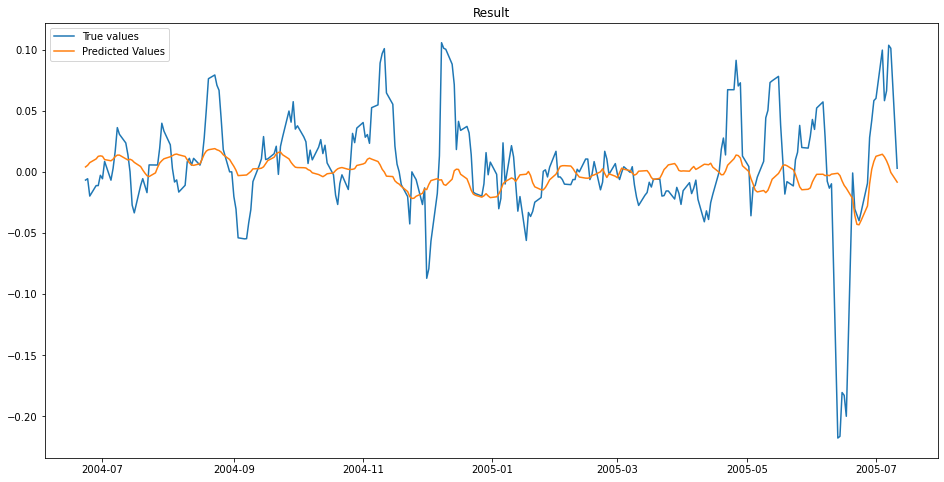


MSE: 0.0018277830847674688

Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 9.4088
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 54 started. Searching for the next optimal point.

learning rate: 0.00036027060747977226
num_input_nodes: 102
dropout: 0.04395199891507324
sequence_length : 157
batch_size: 103



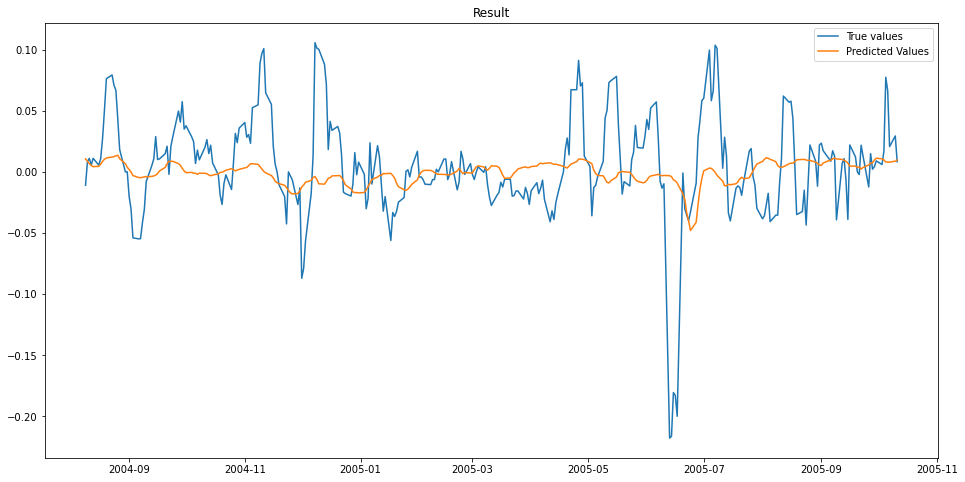


MSE: 0.0018268707095489434

Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 14.1523
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 55 started. Searching for the next optimal point.

learning rate: 0.0007041754428186566
num_input_nodes: 24
dropout: 0.1808445203832612
sequence_length : 193
batch_size: 13



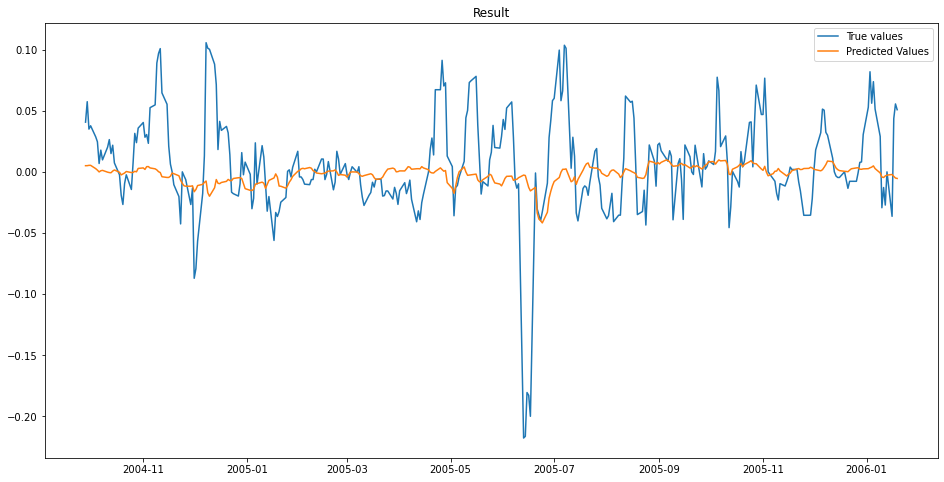


MSE: 0.0017150259803825401

Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 36.8981
Function value obtained: 0.0017
Current minimum: 0.0009
Iteration No: 56 started. Searching for the next optimal point.

learning rate: 0.009919908572416309
num_input_nodes: 75
dropout: 0.06993407026048219
sequence_length : 116
batch_size: 224



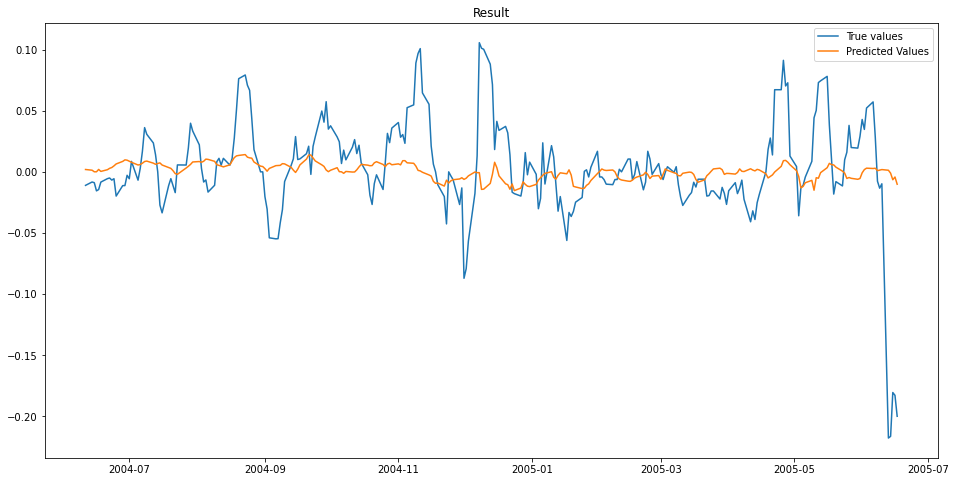


MSE: 0.001756692324251396

Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 10.2881
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 57 started. Searching for the next optimal point.

learning rate: 0.0006092460965235923
num_input_nodes: 240
dropout: 0.11479774344176757
sequence_length : 100
batch_size: 97



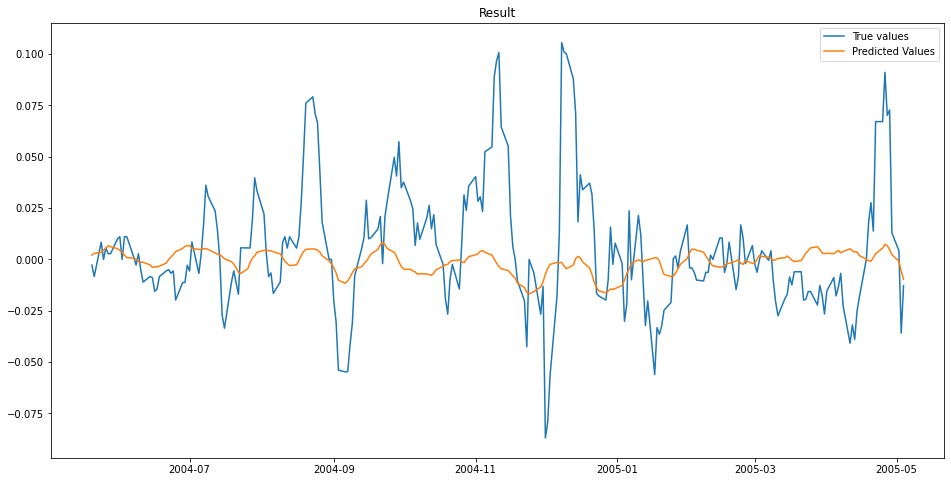


MSE: 0.0009591483621048998

Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 12.3944
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 58 started. Searching for the next optimal point.

learning rate: 0.0009519885287777707
num_input_nodes: 132
dropout: 0.029560473583090864
sequence_length : 146
batch_size: 176



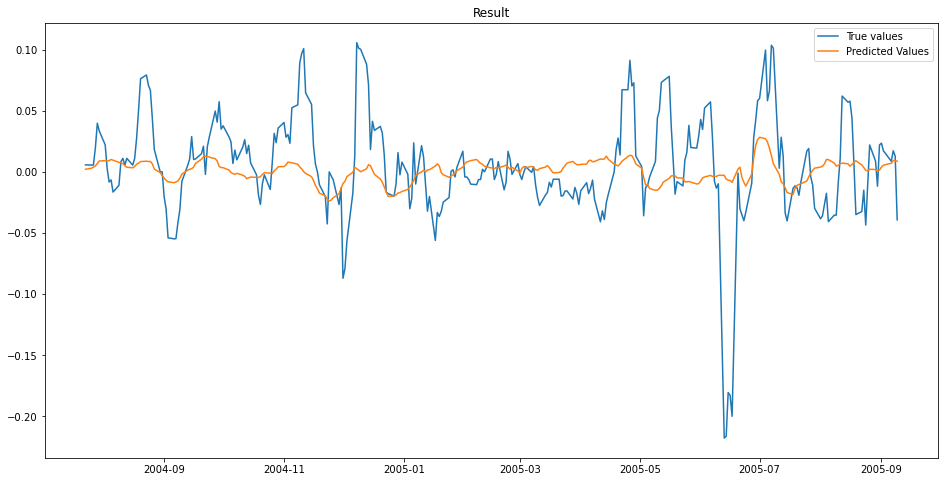


MSE: 0.0017680032109707964

Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 10.7281
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 59 started. Searching for the next optimal point.

learning rate: 0.0005826904090963936
num_input_nodes: 238
dropout: 0.1276547673920787
sequence_length : 100
batch_size: 138



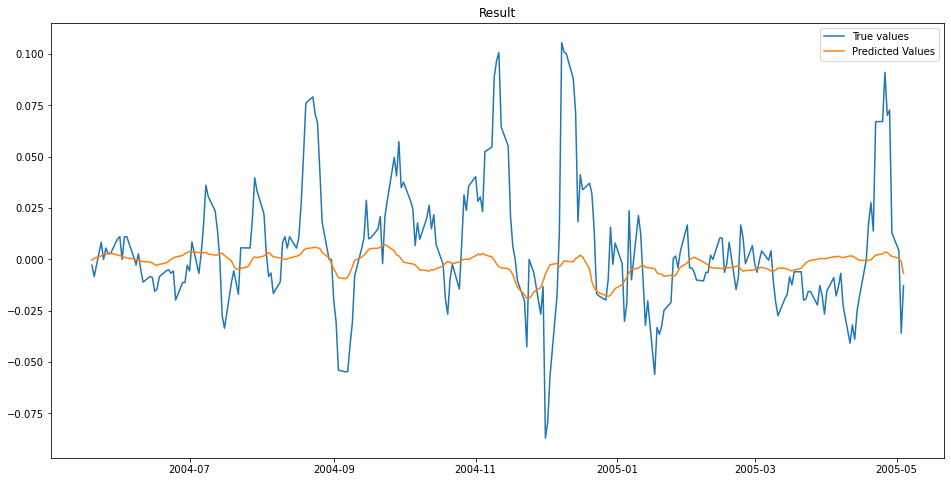


MSE: 0.0009332167128448307

Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 13.5559
Function value obtained: 0.0009
Current minimum: 0.0009
Iteration No: 60 started. Searching for the next optimal point.

learning rate: 0.00010180274711078338
num_input_nodes: 163
dropout: 0.07920302891584906
sequence_length : 176
batch_size: 158



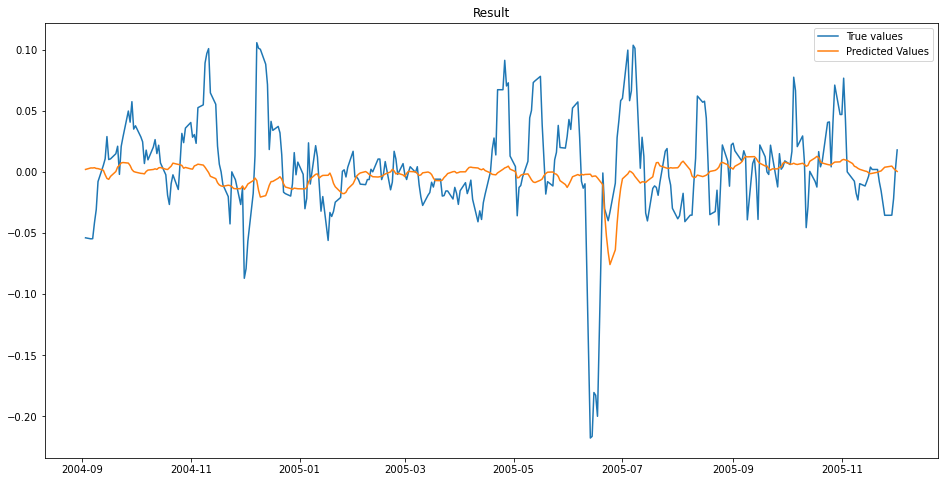


MSE: 0.0018431497919009132

Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 27.2093
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 61 started. Searching for the next optimal point.

learning rate: 0.004601649422606682
num_input_nodes: 85
dropout: 0.015120516756848643
sequence_length : 148
batch_size: 188



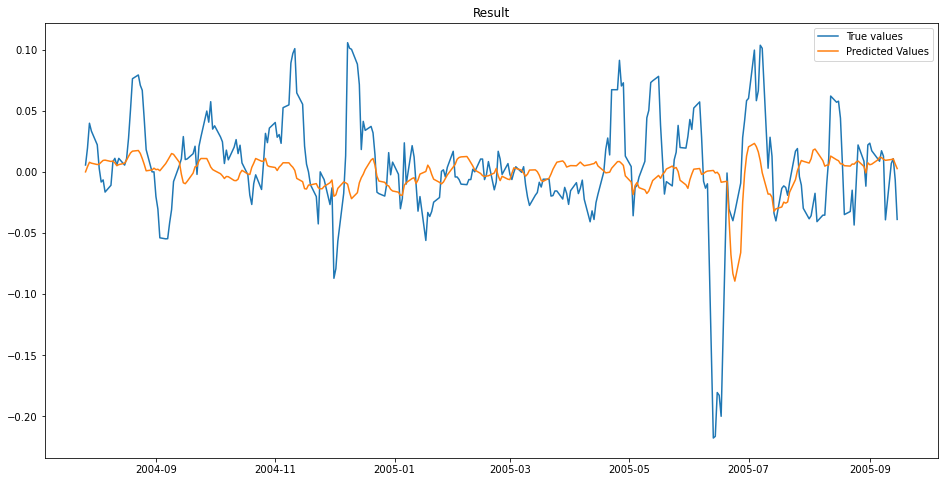


MSE: 0.0019126201049449456

Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 13.8166
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 62 started. Searching for the next optimal point.

learning rate: 0.003778761170677325
num_input_nodes: 207
dropout: 0.17932400172786384
sequence_length : 169
batch_size: 166



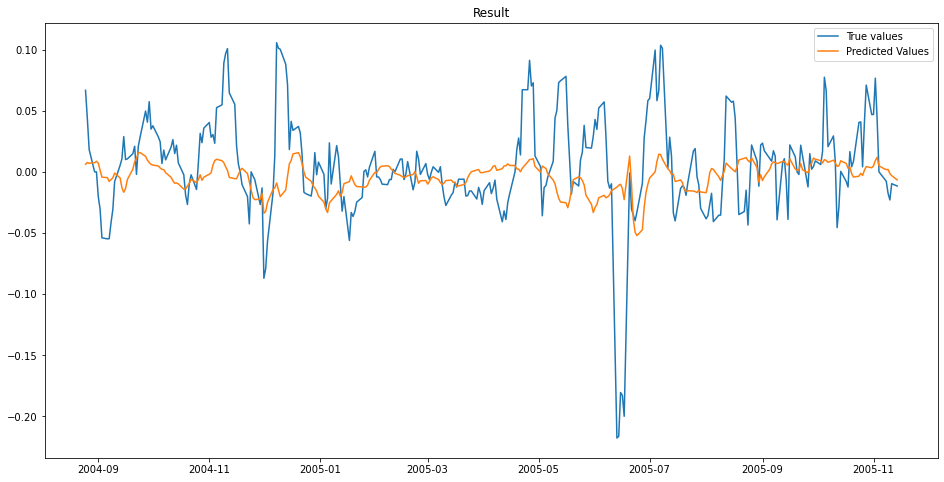


MSE: 0.001787942128705863

Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 31.7347
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 63 started. Searching for the next optimal point.

learning rate: 0.000673280889209292
num_input_nodes: 200
dropout: 0.013169892948874138
sequence_length : 100
batch_size: 39



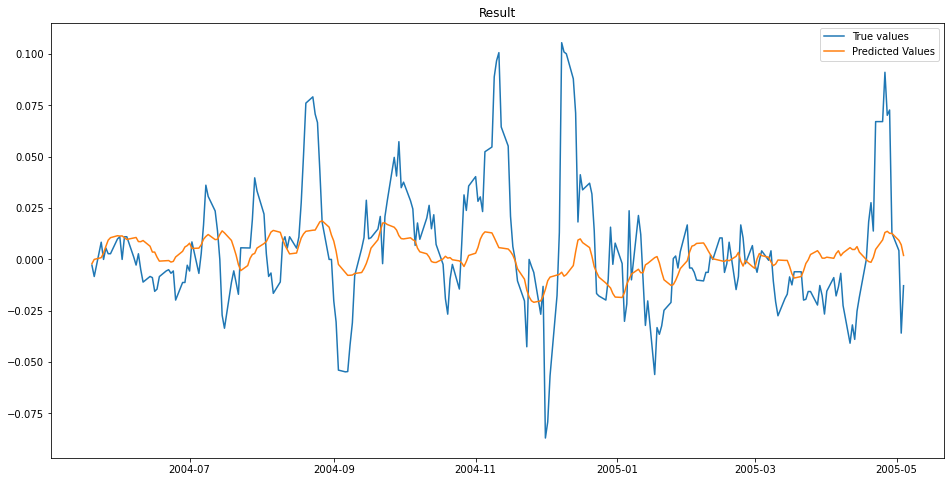


MSE: 0.0008518069877598691

Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 14.5389
Function value obtained: 0.0009
Current minimum: 0.0009
Iteration No: 64 started. Searching for the next optimal point.

learning rate: 0.0007453999441274388
num_input_nodes: 69
dropout: 0.08634610667610078
sequence_length : 100
batch_size: 22



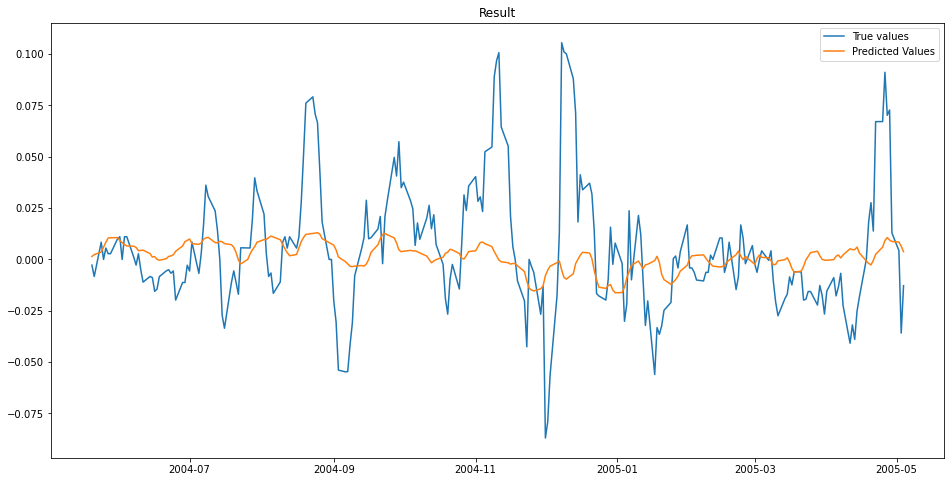


MSE: 0.0009179613416241781

Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 22.1385
Function value obtained: 0.0009
Current minimum: 0.0009
Iteration No: 65 started. Searching for the next optimal point.

learning rate: 0.0006844131434959411
num_input_nodes: 192
dropout: 0.08222278173139931
sequence_length : 100
batch_size: 2



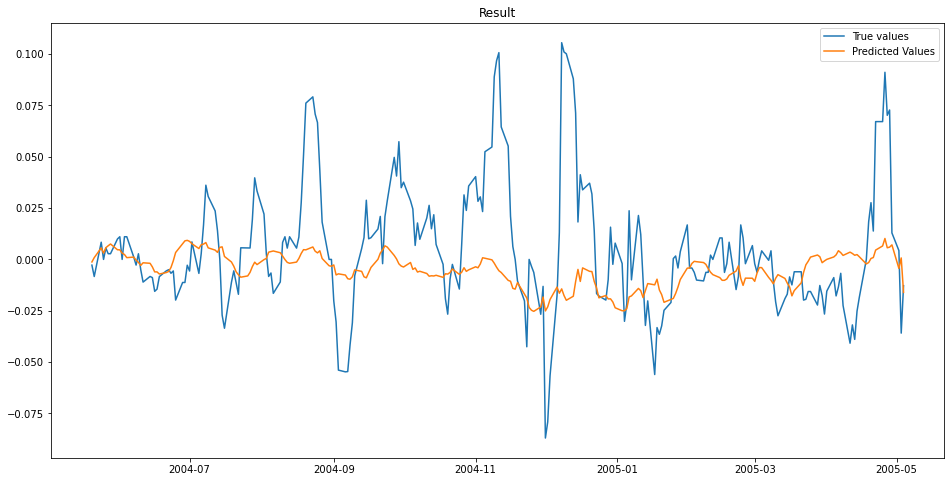


MSE: 0.0010183523999462581

Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 127.7134
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 66 started. Searching for the next optimal point.

learning rate: 0.0005656426756653477
num_input_nodes: 34
dropout: 0.01627277556496751
sequence_length : 100
batch_size: 46



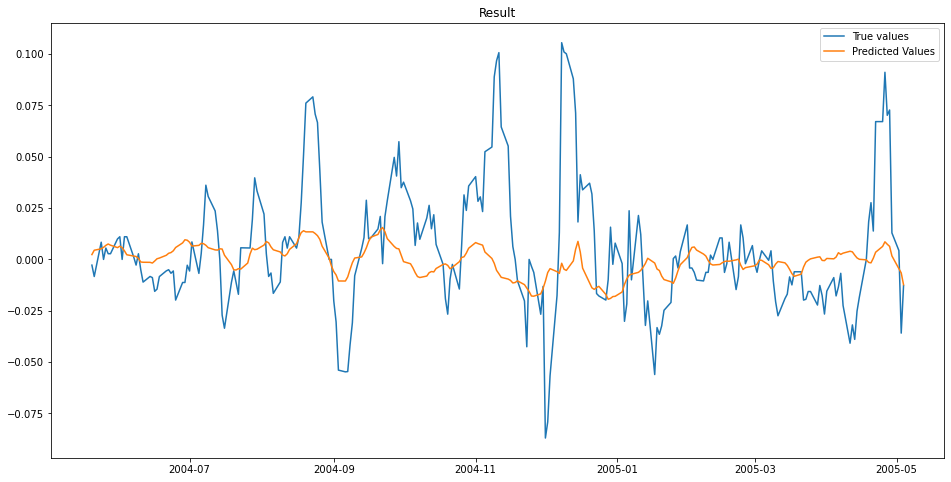


MSE: 0.0009184425690394349

Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 14.5535
Function value obtained: 0.0009
Current minimum: 0.0009
Iteration No: 67 started. Searching for the next optimal point.

learning rate: 0.00014476706831299192
num_input_nodes: 203
dropout: 0.14726485363284803
sequence_length : 200
batch_size: 166



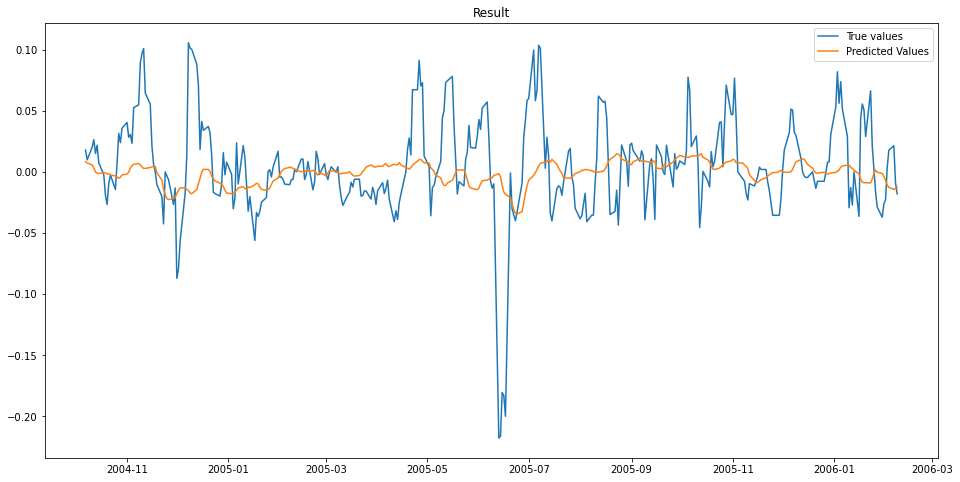


MSE: 0.0017247270476200452

Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 20.8918
Function value obtained: 0.0017
Current minimum: 0.0009
Iteration No: 68 started. Searching for the next optimal point.

learning rate: 0.0001703614412866861
num_input_nodes: 254
dropout: 0.19476335722100108
sequence_length : 100
batch_size: 245



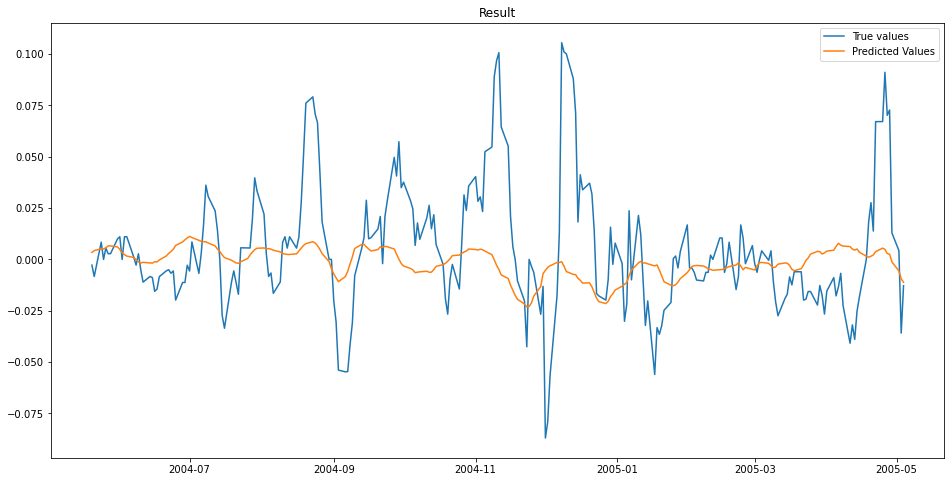


MSE: 0.0009785402298135334

Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 14.2413
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 69 started. Searching for the next optimal point.

learning rate: 0.00022898042712449123
num_input_nodes: 142
dropout: 0.017850679904295817
sequence_length : 167
batch_size: 36



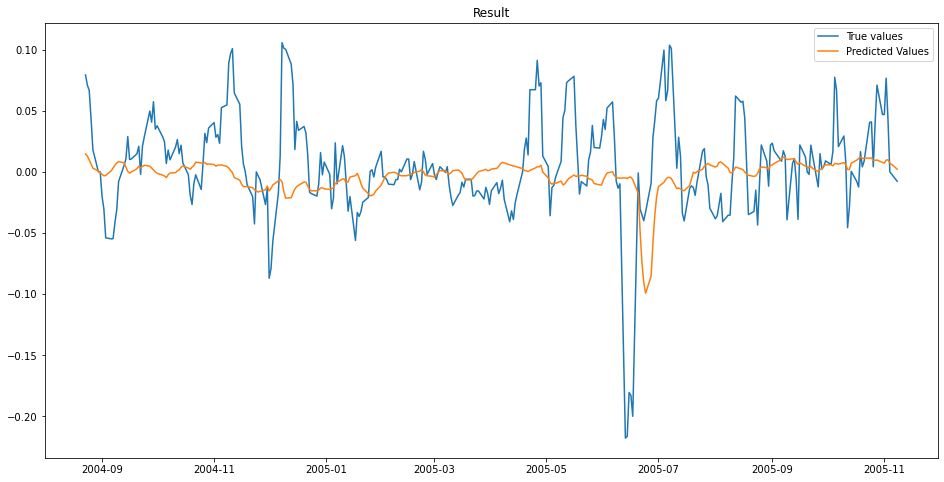


MSE: 0.0019498759077353964

Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 32.1864
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 70 started. Searching for the next optimal point.

learning rate: 0.0006991372671701289
num_input_nodes: 243
dropout: 0.17054229200579496
sequence_length : 100
batch_size: 197



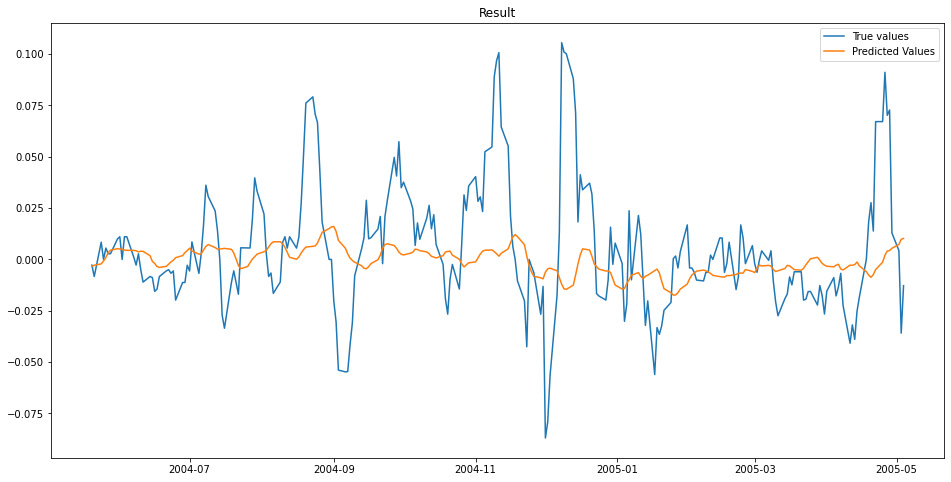


MSE: 0.000992556074172763

Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 12.4659
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 71 started. Searching for the next optimal point.

learning rate: 0.00058470817342269
num_input_nodes: 95
dropout: 0.038344310766035346
sequence_length : 100
batch_size: 195



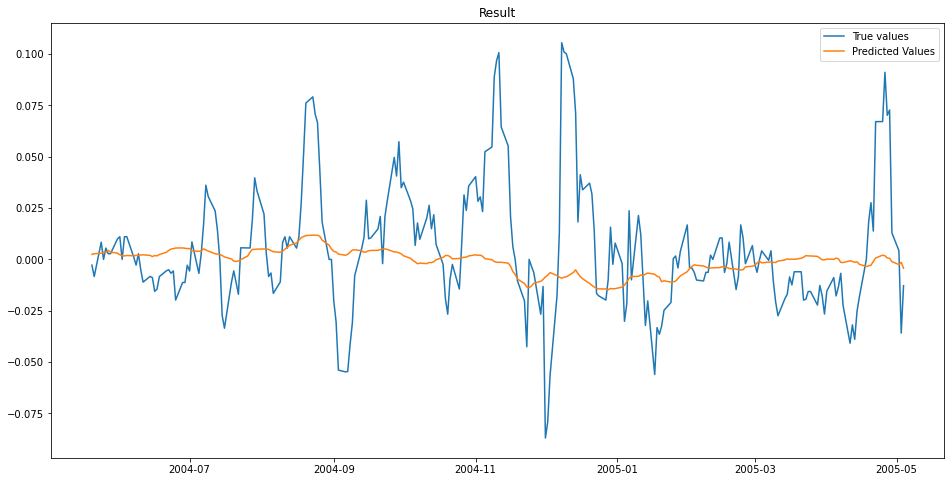


MSE: 0.000966933809873282

Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 10.3297
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 72 started. Searching for the next optimal point.

learning rate: 0.001934714882000995
num_input_nodes: 14
dropout: 0.1496472888041074
sequence_length : 176
batch_size: 40



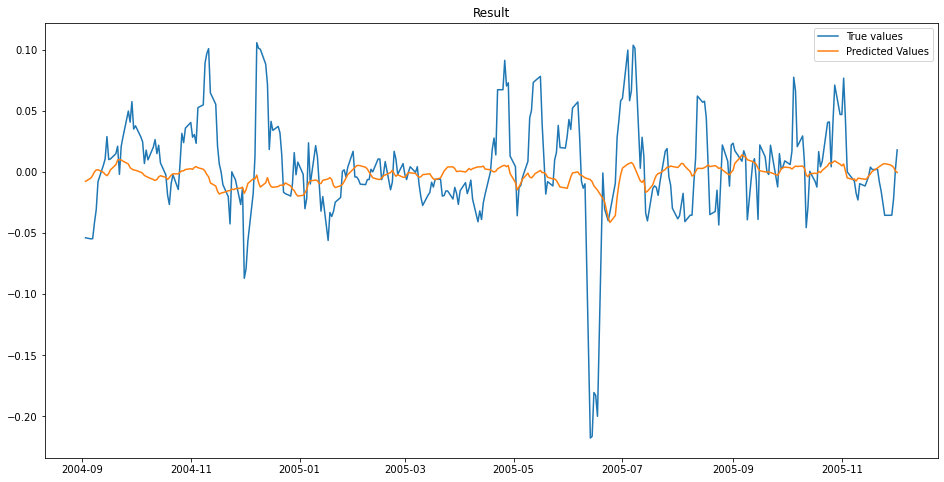


MSE: 0.0017037584708825722

Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 18.2151
Function value obtained: 0.0017
Current minimum: 0.0009
Iteration No: 73 started. Searching for the next optimal point.

learning rate: 0.0001960116571995673
num_input_nodes: 238
dropout: 0.016410823138326067
sequence_length : 128
batch_size: 216



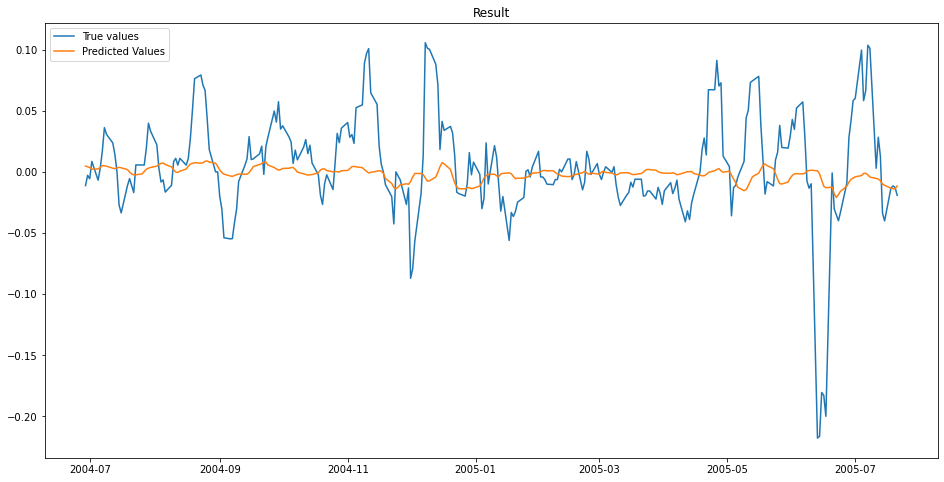


MSE: 0.001879818175694133

Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 14.3657
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 74 started. Searching for the next optimal point.

learning rate: 0.0016564469777783752
num_input_nodes: 168
dropout: 0.10476539484311784
sequence_length : 179
batch_size: 71



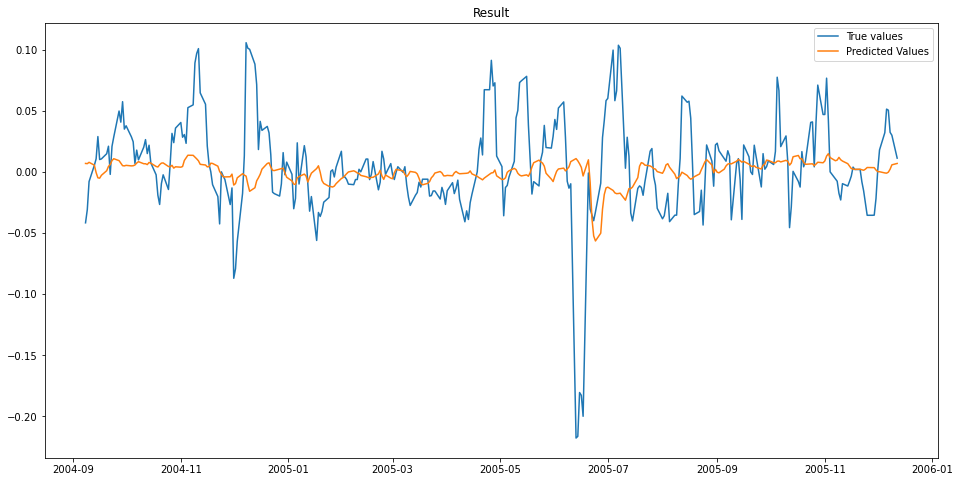


MSE: 0.0018342201840048367

Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 17.1064
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 75 started. Searching for the next optimal point.

learning rate: 0.00020458807202446572
num_input_nodes: 88
dropout: 0.2289375289856191
sequence_length : 199
batch_size: 222



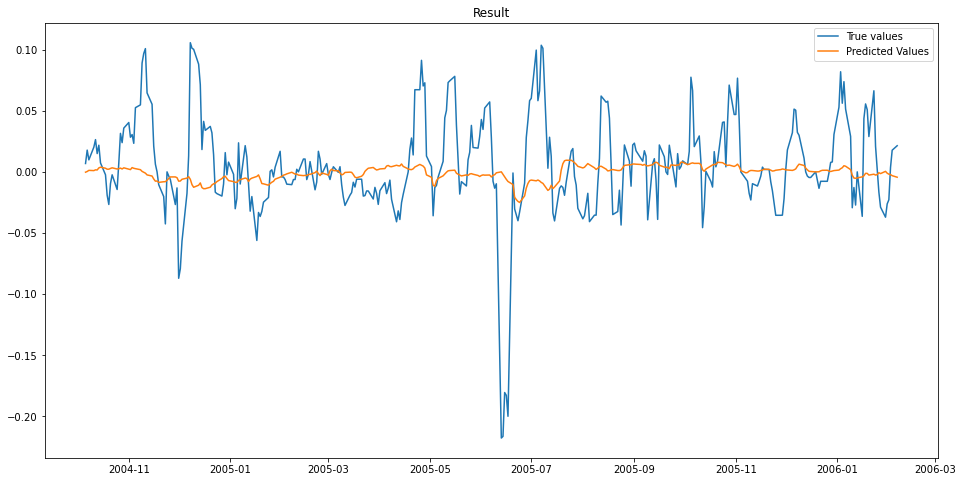


MSE: 0.0017326256457297037

Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 12.7804
Function value obtained: 0.0017
Current minimum: 0.0009
Iteration No: 76 started. Searching for the next optimal point.

learning rate: 0.00936354814193516
num_input_nodes: 58
dropout: 0.018650182734457125
sequence_length : 177
batch_size: 155



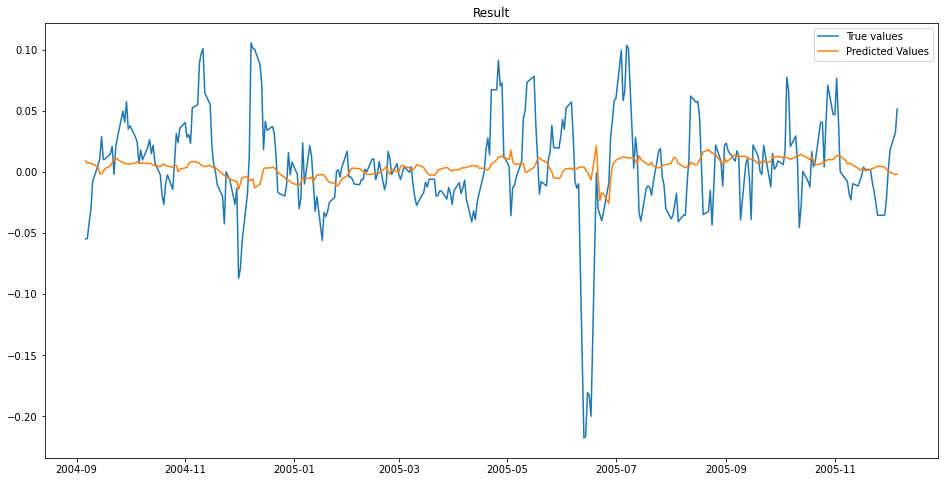


MSE: 0.0017036316070028002

Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 12.1145
Function value obtained: 0.0017
Current minimum: 0.0009
Iteration No: 77 started. Searching for the next optimal point.

learning rate: 0.0006277318630327672
num_input_nodes: 170
dropout: 0.17310481009819254
sequence_length : 195
batch_size: 179



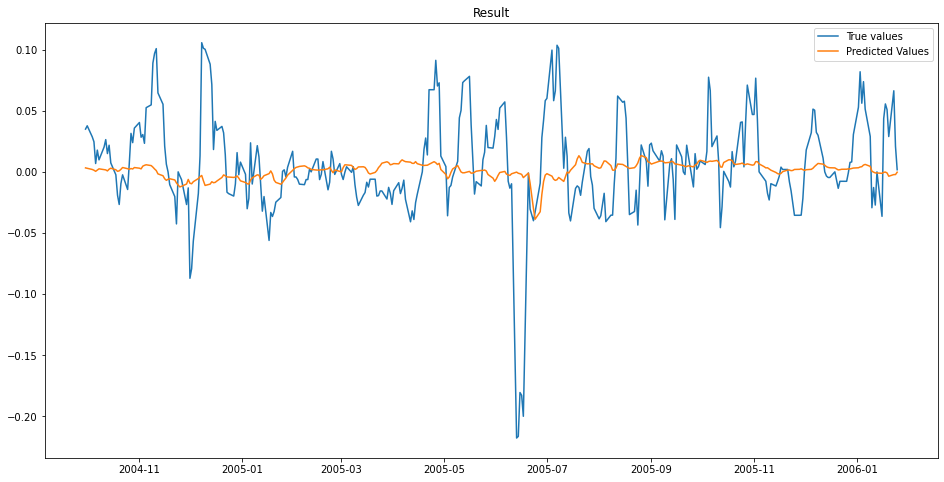


MSE: 0.0017385289885620168

Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 18.7895
Function value obtained: 0.0017
Current minimum: 0.0009
Iteration No: 78 started. Searching for the next optimal point.

learning rate: 0.00044969035046120144
num_input_nodes: 20
dropout: 0.027100105220927324
sequence_length : 100
batch_size: 47



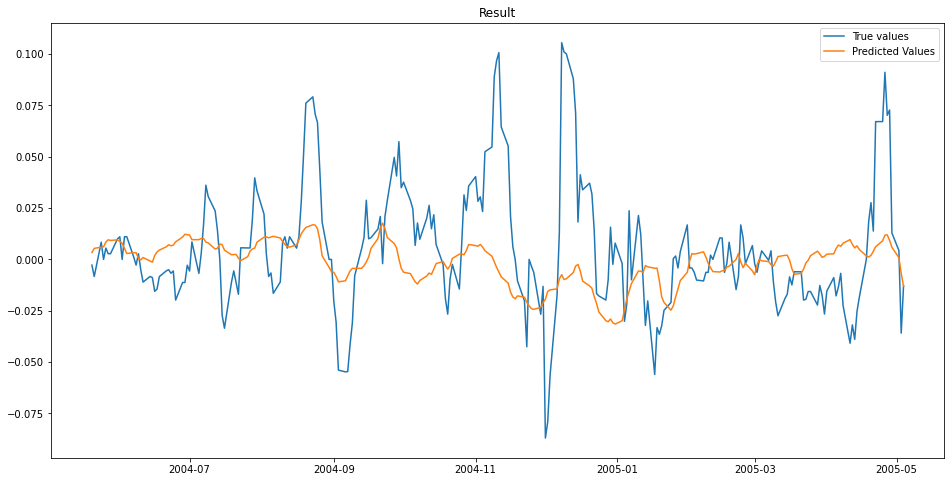


MSE: 0.000966582164382552

Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 13.6110
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 79 started. Searching for the next optimal point.

learning rate: 0.0024768316121782804
num_input_nodes: 166
dropout: 0.015770349364863216
sequence_length : 128
batch_size: 83



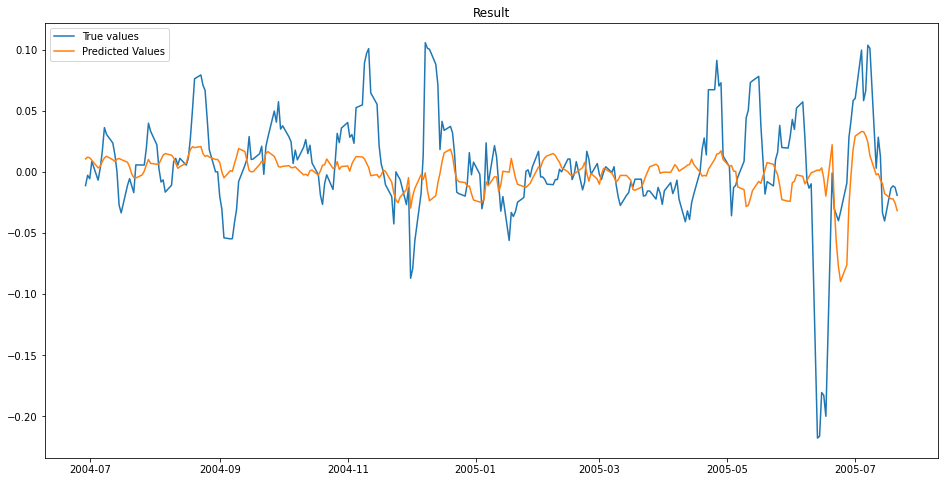


MSE: 0.0018666007135747984

Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 20.9034
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 80 started. Searching for the next optimal point.

learning rate: 0.0011848875333369338
num_input_nodes: 148
dropout: 0.1820547760128416
sequence_length : 186
batch_size: 112



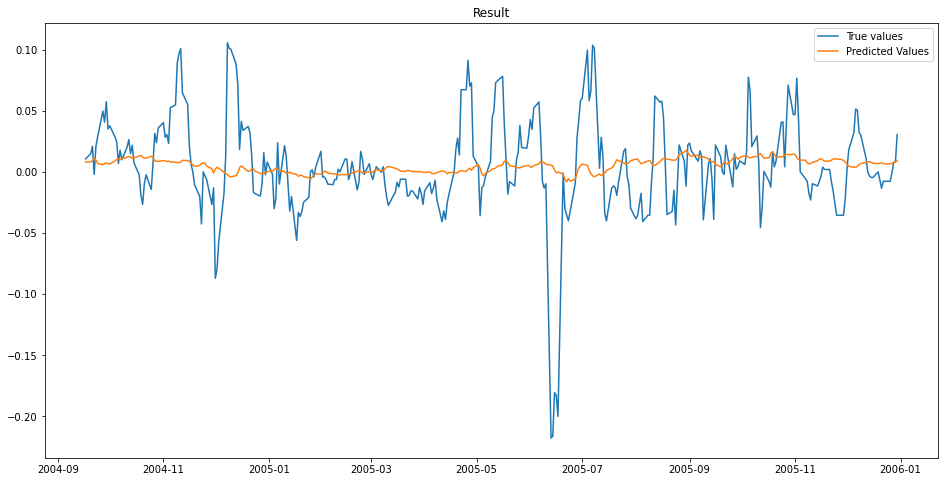


MSE: 0.0016768269037401844

Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 13.6581
Function value obtained: 0.0017
Current minimum: 0.0009
Iteration No: 81 started. Searching for the next optimal point.

learning rate: 0.0006848369351694641
num_input_nodes: 17
dropout: 0.2025874244582799
sequence_length : 100
batch_size: 228



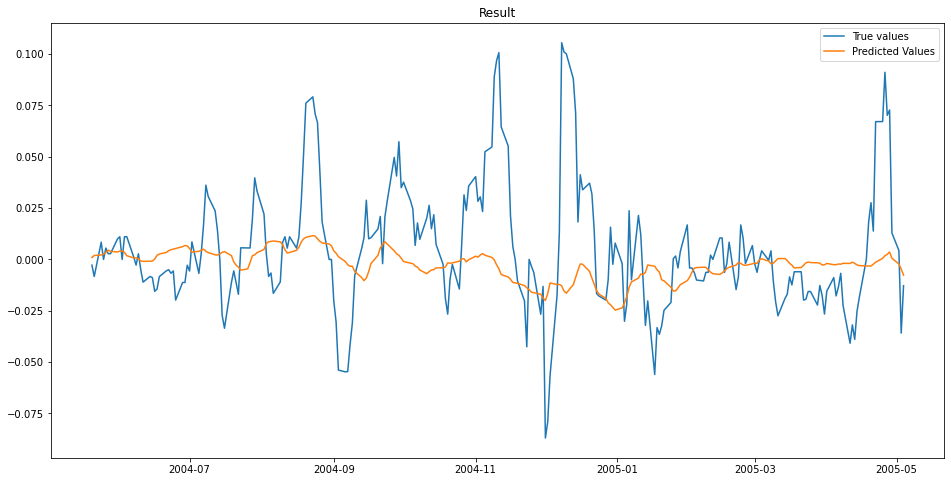


MSE: 0.0009981814746049232

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 10.6649
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 82 started. Searching for the next optimal point.

learning rate: 0.002827388517269168
num_input_nodes: 209
dropout: 0.17279149398322147
sequence_length : 117
batch_size: 247



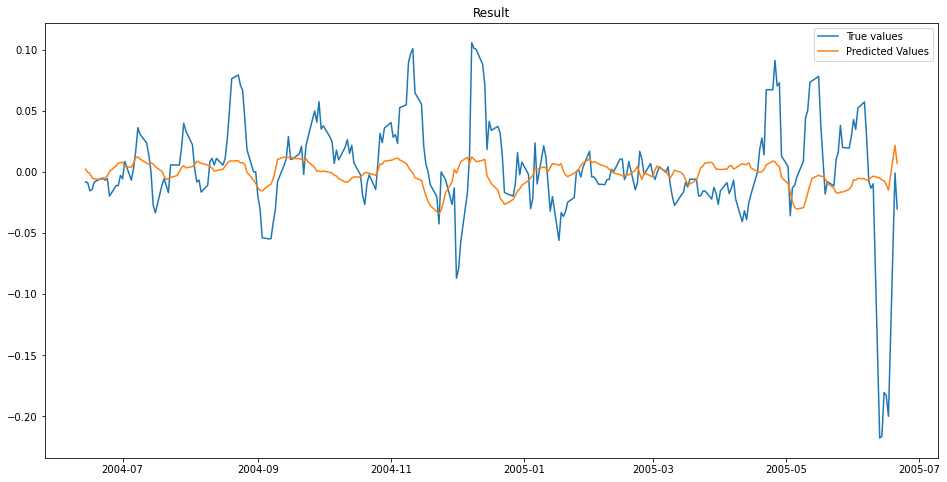


MSE: 0.0017599825162128854

Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 14.8553
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 83 started. Searching for the next optimal point.

learning rate: 0.0010175461262211167
num_input_nodes: 159
dropout: 0.21268918654950092
sequence_length : 117
batch_size: 96



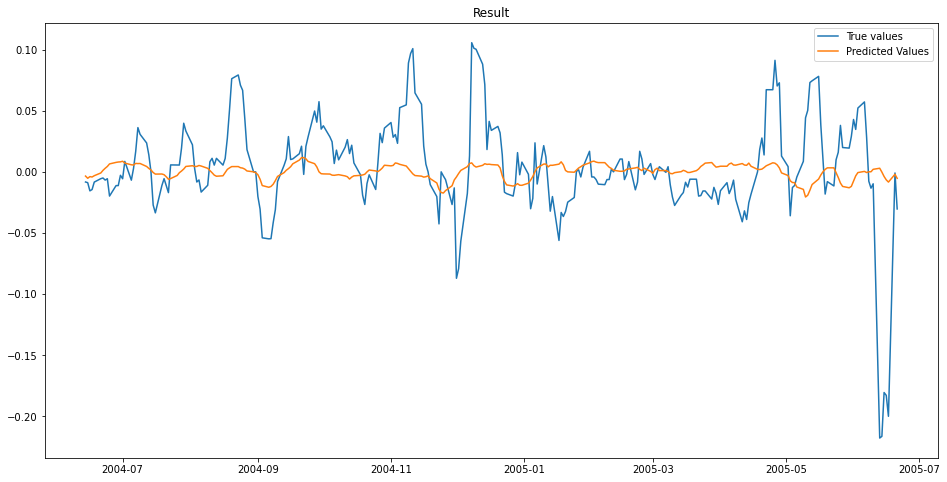


MSE: 0.0017784065092910353

Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 15.4083
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 84 started. Searching for the next optimal point.

learning rate: 0.0019620658397930023
num_input_nodes: 247
dropout: 0.0796603052293783
sequence_length : 141
batch_size: 82



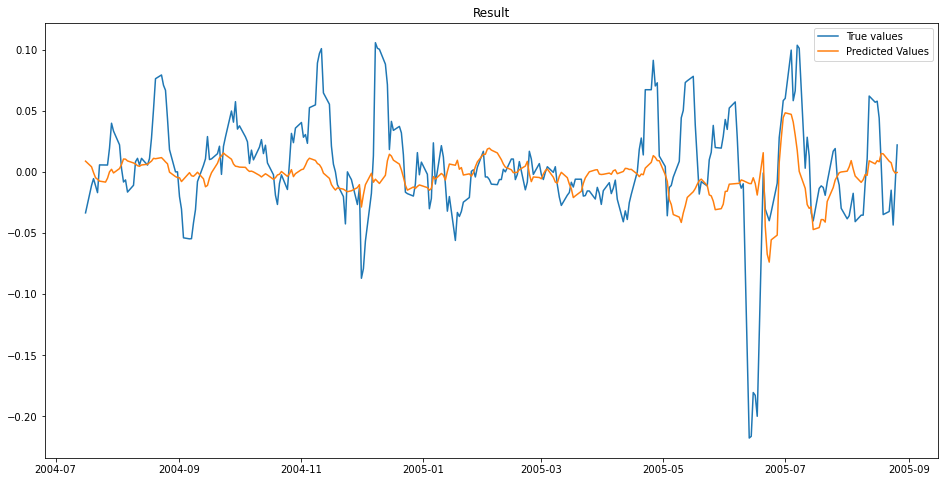


MSE: 0.0018476668547252285

Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 26.7285
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 85 started. Searching for the next optimal point.

learning rate: 0.008043191210903316
num_input_nodes: 42
dropout: 0.22844898929603968
sequence_length : 113
batch_size: 68



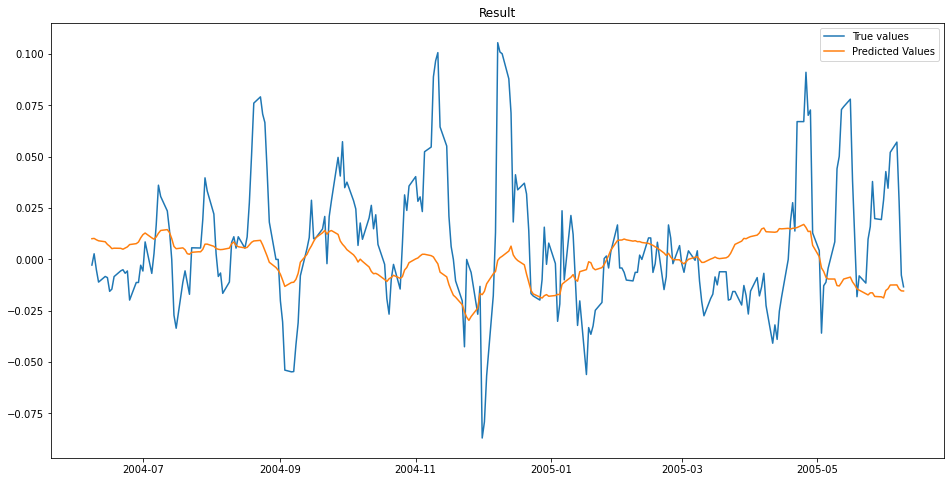


MSE: 0.0010874531125210304

Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 12.2309
Function value obtained: 0.0011
Current minimum: 0.0009
Iteration No: 86 started. Searching for the next optimal point.

learning rate: 0.0038009778724640993
num_input_nodes: 232
dropout: 0.12491961823757344
sequence_length : 136
batch_size: 71



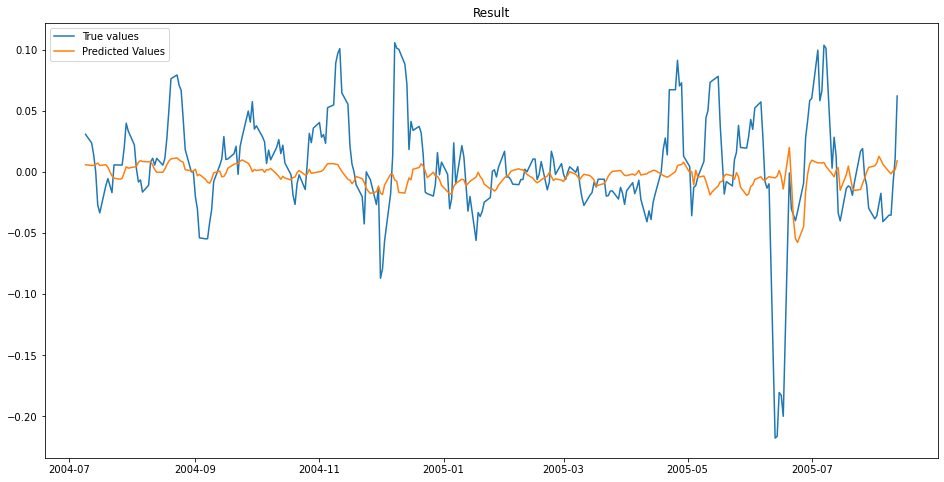


MSE: 0.0018850902828930803

Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 19.2691
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 87 started. Searching for the next optimal point.

learning rate: 0.005333059284877444
num_input_nodes: 28
dropout: 0.10729957267690465
sequence_length : 105
batch_size: 246



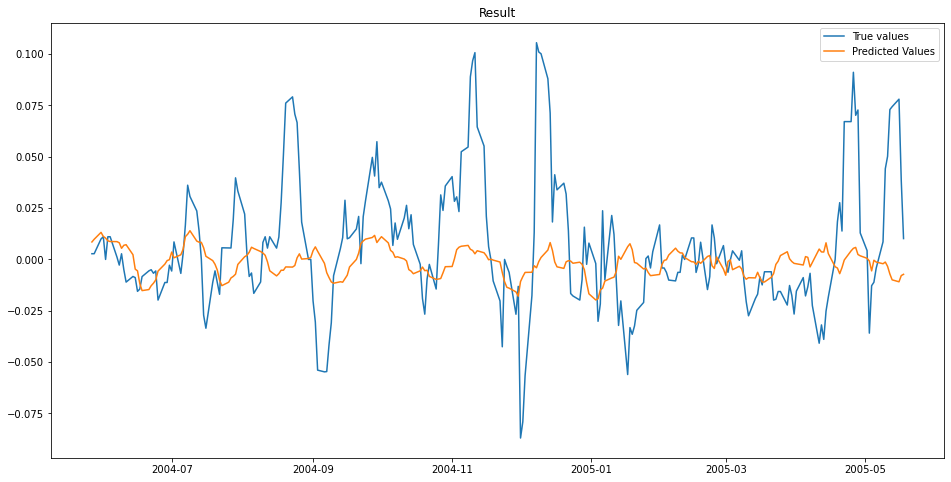


MSE: 0.0010457678055018054

Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 8.4253
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 88 started. Searching for the next optimal point.

learning rate: 0.0001477443660864128
num_input_nodes: 152
dropout: 0.13384018712408904
sequence_length : 181
batch_size: 59



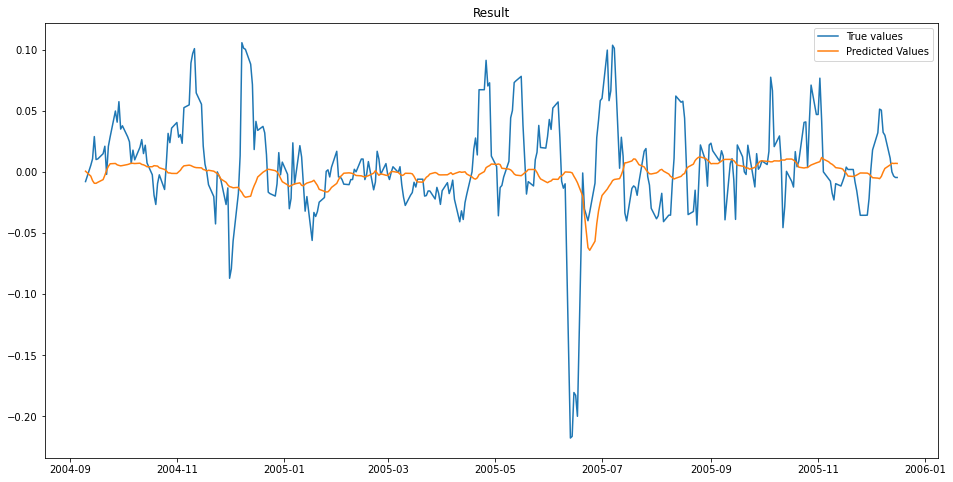


MSE: 0.001824620690476852

Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 17.9735
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 89 started. Searching for the next optimal point.

learning rate: 0.0001
num_input_nodes: 5
dropout: 0.07081310258277317
sequence_length : 101
batch_size: 1



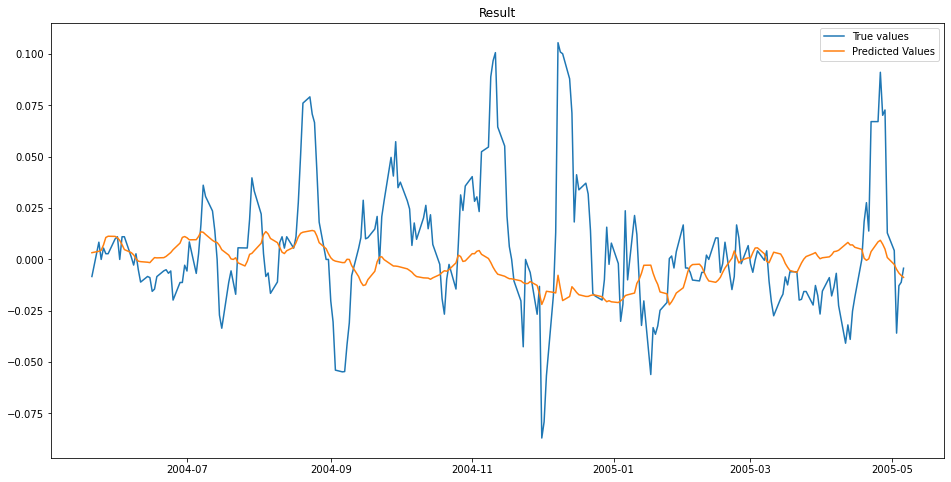


MSE: 0.0010409869993502237

Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 410.2909
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 90 started. Searching for the next optimal point.

learning rate: 0.003733473307491649
num_input_nodes: 106
dropout: 0.1397351285801814
sequence_length : 131
batch_size: 27



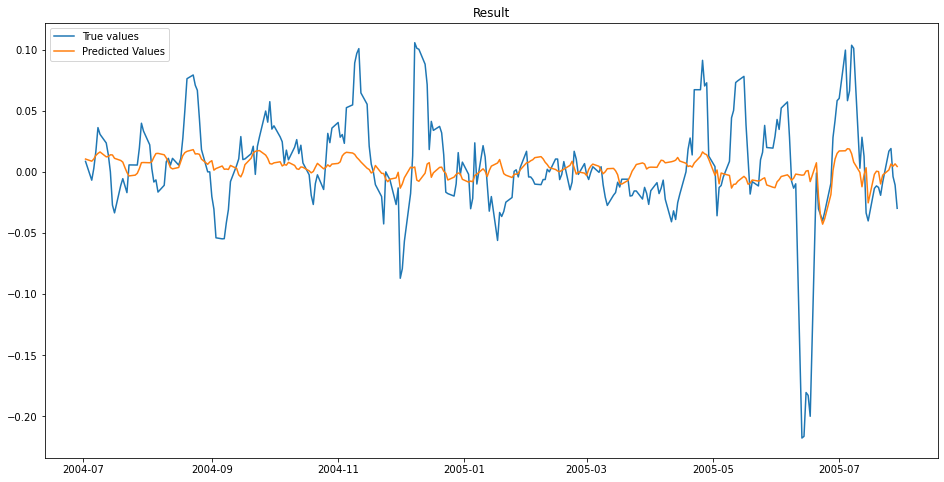


MSE: 0.0017600937540557377

Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 35.0518
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 91 started. Searching for the next optimal point.

learning rate: 0.01
num_input_nodes: 202
dropout: 0.02437650379316218
sequence_length : 101
batch_size: 107



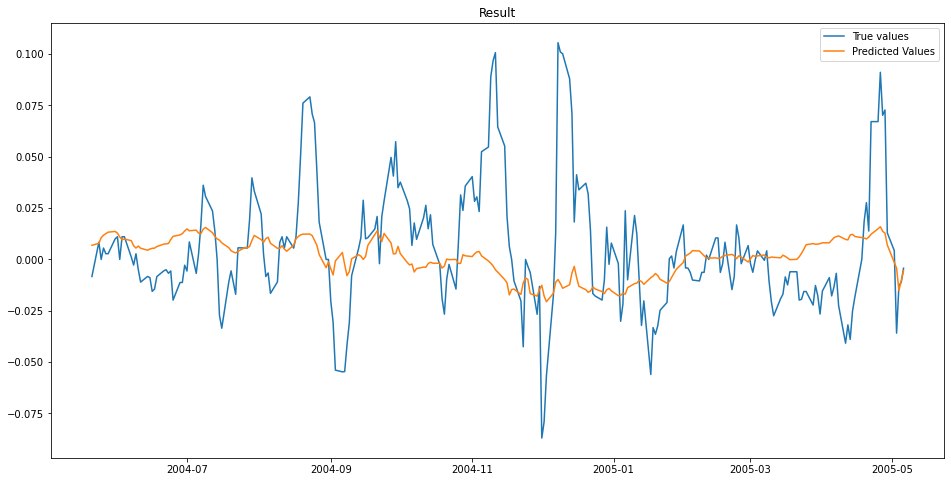


MSE: 0.0009778010684584485

Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 15.5293
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 92 started. Searching for the next optimal point.

learning rate: 0.0001
num_input_nodes: 256
dropout: 0.14458787271884233
sequence_length : 101
batch_size: 22



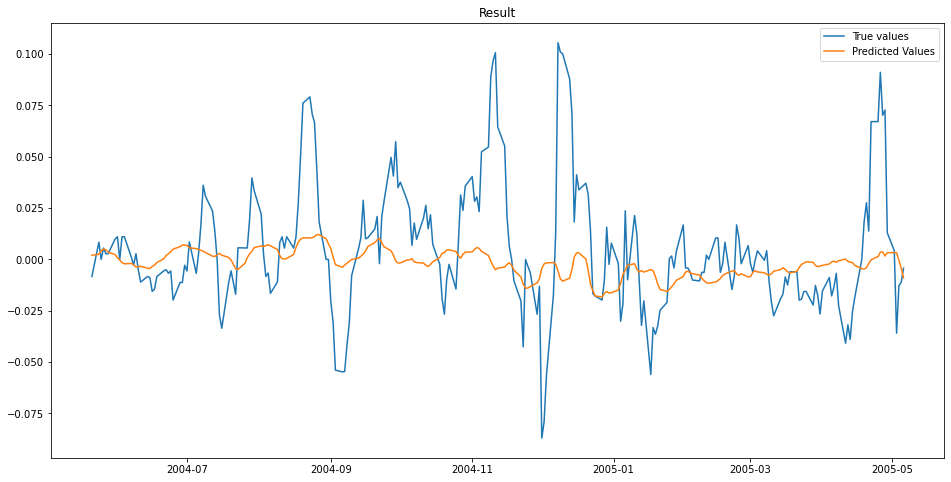


MSE: 0.000954507980331867

Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 22.9541
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 93 started. Searching for the next optimal point.

learning rate: 0.001454010611221609
num_input_nodes: 52
dropout: 0.09308903147973126
sequence_length : 116
batch_size: 182



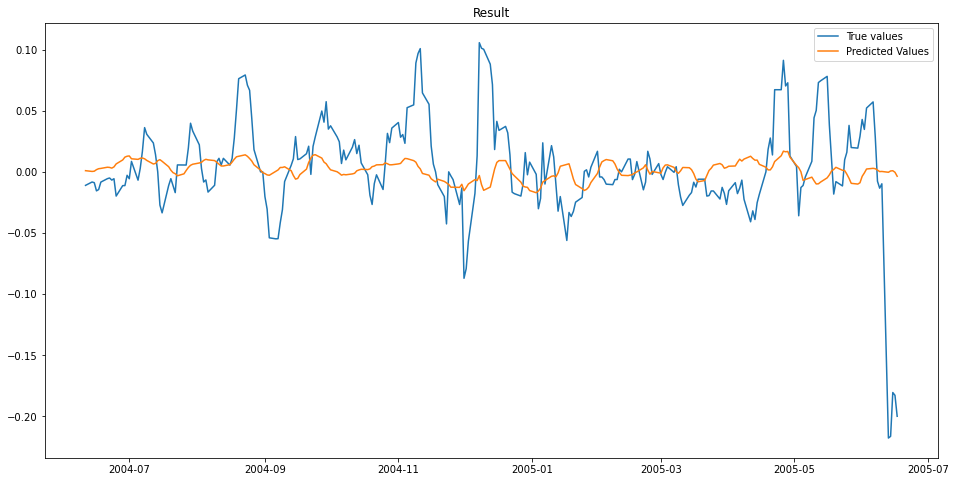


MSE: 0.0017825062076114054

Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 9.7048
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 94 started. Searching for the next optimal point.

learning rate: 0.00013922483491784666
num_input_nodes: 57
dropout: 0.00809265959299685
sequence_length : 154
batch_size: 51



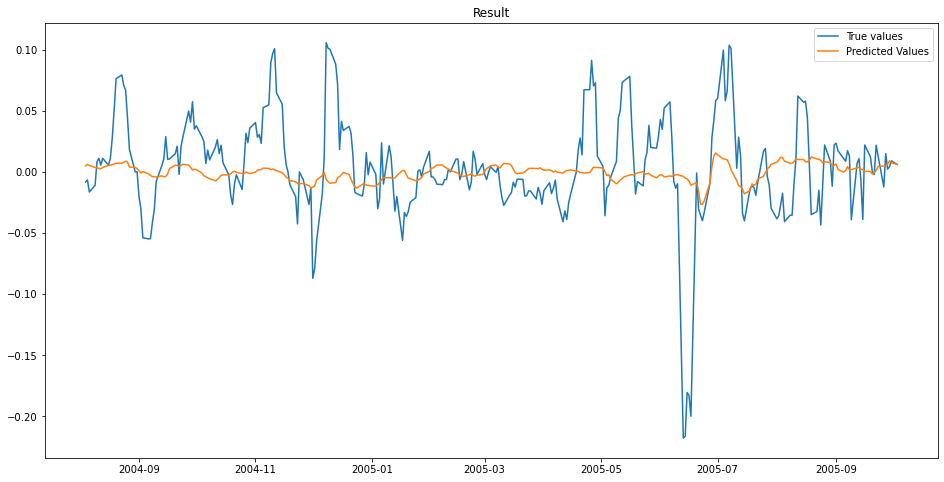


MSE: 0.0017771364299627563

Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 19.8629
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 95 started. Searching for the next optimal point.

learning rate: 0.0001
num_input_nodes: 206
dropout: 0.005679780152514924
sequence_length : 101
batch_size: 105



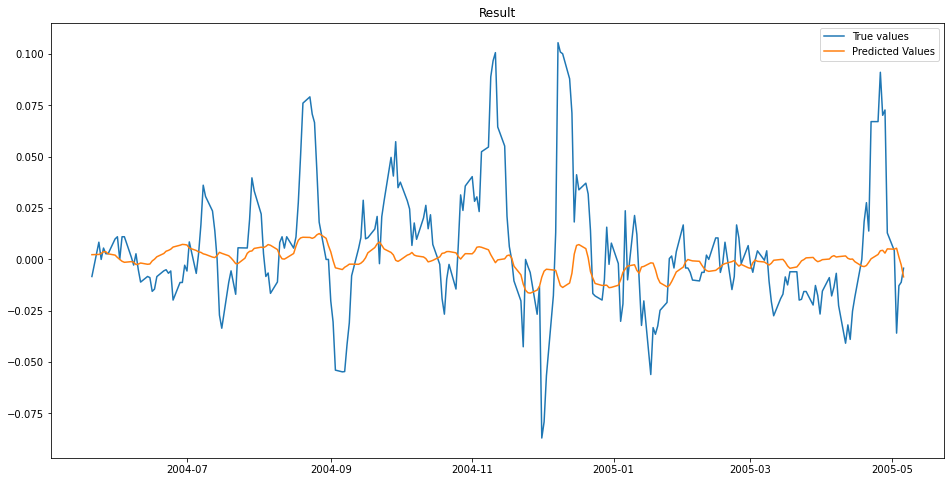


MSE: 0.0009415315752330018

Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 16.6822
Function value obtained: 0.0009
Current minimum: 0.0009
Iteration No: 96 started. Searching for the next optimal point.

learning rate: 0.0001
num_input_nodes: 256
dropout: 0.0
sequence_length : 101
batch_size: 179



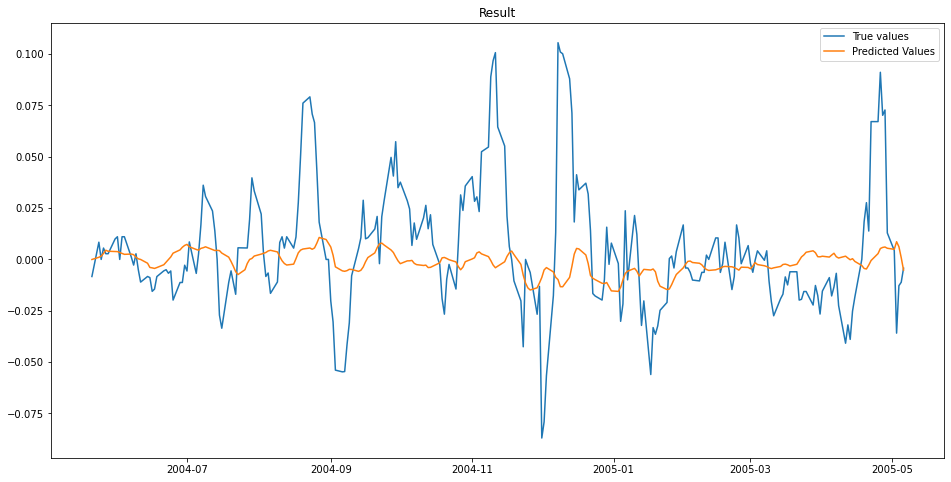


MSE: 0.0009743978193732126

Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 12.1483
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 97 started. Searching for the next optimal point.

learning rate: 0.0002890880806223456
num_input_nodes: 237
dropout: 0.12307850504510529
sequence_length : 160
batch_size: 232



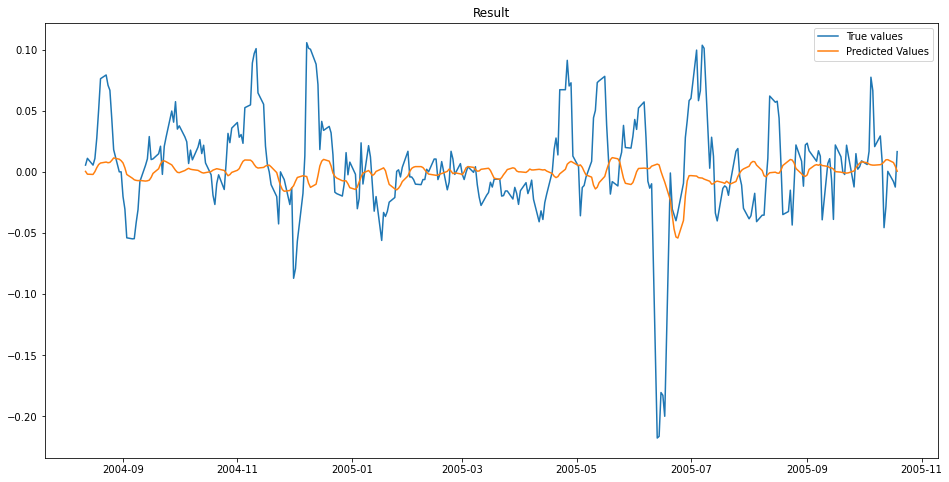


MSE: 0.0018820058088760104

Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 17.9755
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 98 started. Searching for the next optimal point.

learning rate: 0.01
num_input_nodes: 32
dropout: 0.10613701652665376
sequence_length : 101
batch_size: 41



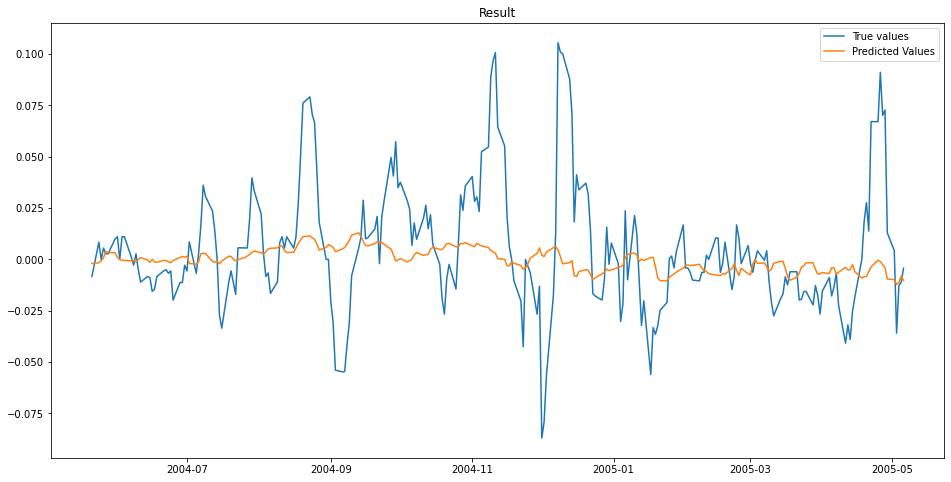


MSE: 0.0009371615469466828

Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 12.1855
Function value obtained: 0.0009
Current minimum: 0.0009
Iteration No: 99 started. Searching for the next optimal point.

learning rate: 0.003616015748745711
num_input_nodes: 40
dropout: 0.03119878374184159
sequence_length : 101
batch_size: 10



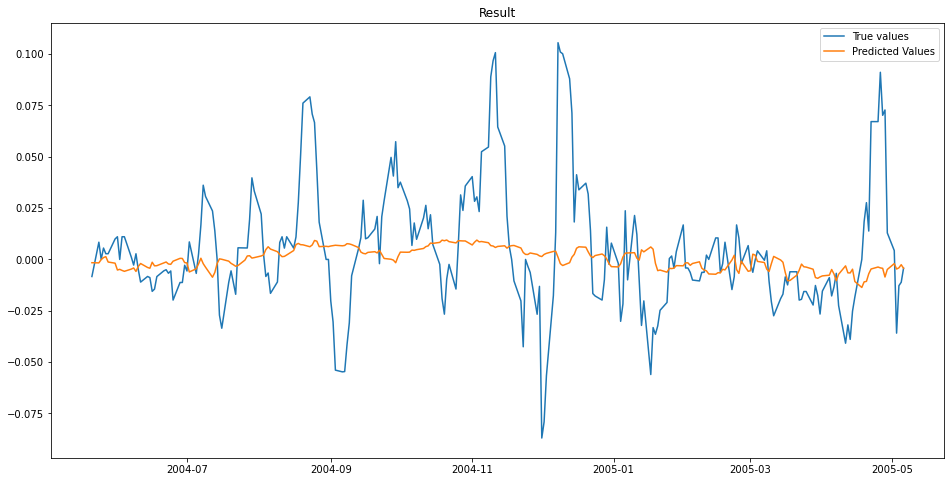


MSE: 0.0009583164842996595

Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 24.9028
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 100 started. Searching for the next optimal point.

learning rate: 0.00011721775002593032
num_input_nodes: 39
dropout: 0.12976722869907892
sequence_length : 174
batch_size: 136



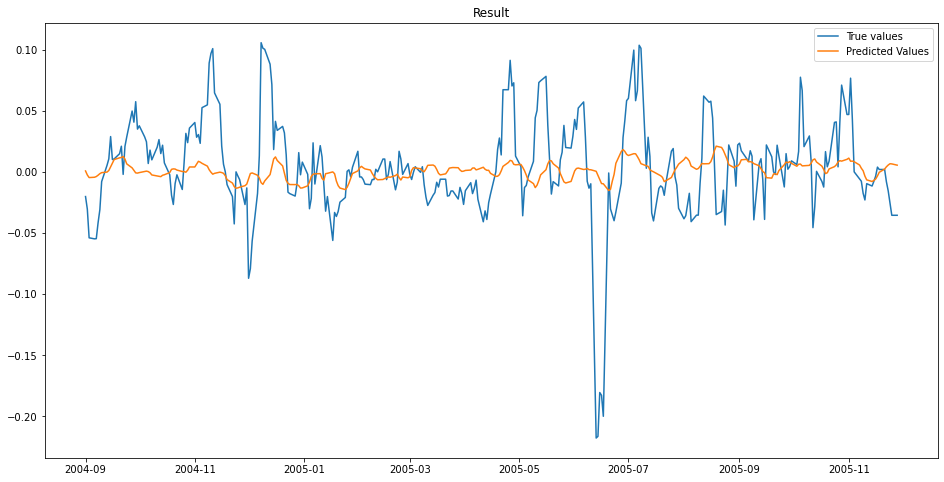


MSE: 0.0017070551344928494

Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 13.4184
Function value obtained: 0.0017
Current minimum: 0.0009


In [10]:
gp_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            n_jobs=-1,
                            n_random_starts=10,
                            verbose=True,
                            x0=default_parameters,
                            random_state=randseed)

**Summary of configurations and results**

In [11]:
res = pd.concat([pd.DataFrame(gp_result.x_iters, columns = ['learning_rate', 'num_input_nodes', 'dropout', 'sequencelength', 'batch_size']),(pd.Series(gp_result.func_vals, name="mse"))], axis=1)
res = res.sort_values(by='mse')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(res)

learning_rate  num_input_nodes   dropout  sequencelength  batch_size  \
48       0.000514              145  0.232331             100         249   
62       0.000673              200  0.013170             100          39   
63       0.000745               69  0.086346             100          22   
65       0.000566               34  0.016273             100          46   
20       0.000100              211  0.028086             102         170   
35       0.000553               41  0.008490             102         249   
58       0.000583              238  0.127655             100         138   
97       0.010000               32  0.106137             101          41   
94       0.000100              206  0.005680             101         105   
19       0.000307              112  0.247040             102          59   
91       0.000100              256  0.144588             101          22   
98       0.003616               40  0.031199             101          10   
56       0.000609              240  0.114798             100          97   
77       0.000450               20  0.027100             100          47   
70       0.000585               95  0.038344             100         195   
95       0.000100              256  0.000000             101         179   
90       0.010000              202  0.024377             101         107   
67       0.000170              254  0.194763             100         245   
4        0.001718              159  0.001767             102         132   
42       0.000100              189  0.141084             100         142   
34       0.000423              251  0.104889             100          63   
69       0.000699              243  0.170542             100         197   
3        0.000130              186  0.234638             100         248   
25       0.000457               12  0.073448             100         241   
80       0.000685               17  0.202587             100         228   
64       0.000684              192  0.082223             100           2   
49       0.001520              144  0.129239             107         181   
18       0.000100               69  0.000000             105         217   
12       0.001106              247  0.239615             105          66   
88       0.000100                5  0.070813             101           1   
23       0.000100              233  0.128680             103          36   
36       0.000880                5  0.080901             103         240   
86       0.005333               28  0.107300             105         246   
29       0.002007               53  0.159039             110         151   
17       0.010000              190  0.229486             100         225   
84       0.008043               42  0.228449             113          68   
43       0.000160              181  0.086045             110          34   
24       0.000286              124  0.198719             112          17   
2        0.000158              120  0.083427             114         163   
37       0.001385              149  0.045949             114          57   
39       0.000250              244  0.119440             114         166   
21       0.010000              221  0.223688             110         225   
16       0.002843              172  0.006246             198         119   
79       0.001185              148  0.182055             186         112   
22       0.000104                8  0.097182             178          82   
75       0.009364               58  0.018650             177         155   
71       0.001935               14  0.149647             176          40   
99       0.000117               39  0.129767             174         136   
44       0.002576              217  0.180083             187          33   
54       0.000704               24  0.180845             193          13   
66       0.000145              203  0.147265             200         166   
28       0.000434              207  0.051118        